<a href="https://colab.research.google.com/github/ShanRinna/DL3/blob/main/DNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
import tensorflow as tf
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7763162549598571653
 xla_global_id: -1]

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name)>0:
    print(f'GPU has been found... device name is{device_name}')
else:
    print('No GPU has been found...')

GPU has been found... device name is/device:GPU:0


In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [3]:
#df = pd.read_csv('/content/sample_data/House_Rent_Dataset.csv') #y:連續變數
# Colab
df = pd.read_csv('/content/House_Rent_Dataset.csv')
df

Rent  Size  BHK  Bathroom Furnishing Status       City
0     10000  1100    2         2       Unfurnished    Kolkata
1     20000   800    2         1    Semi-Furnished    Kolkata
2     17000  1000    2         1    Semi-Furnished    Kolkata
3     10000   800    2         1       Unfurnished    Kolkata
4      7500   850    2         1       Unfurnished    Kolkata
...     ...   ...  ...       ...               ...        ...
4741  15000  1000    2         2    Semi-Furnished  Hyderabad
4742  29000  2000    3         3    Semi-Furnished  Hyderabad
4743  35000  1750    3         3    Semi-Furnished  Hyderabad
4744  45000  1500    3         2    Semi-Furnished  Hyderabad
4745  15000  1000    2         2       Unfurnished  Hyderabad

[4746 rows x 6 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rent               4746 non-null   int64 
 1   Size               4746 non-null   int64 
 2   BHK                4746 non-null   int64 
 3   Bathroom           4746 non-null   int64 
 4   Furnishing Status  4746 non-null   object
 5   City               4746 non-null   object
dtypes: int64(4), object(2)
memory usage: 222.6+ KB


In [5]:
print(df[['Furnishing Status']].value_counts(sort=True))
print('+-----------------------+')
print(df[['City']].value_counts(sort=True))
print('+-----------------------+')

Furnishing Status
Semi-Furnished       2251
Unfurnished          1815
Furnished             680
dtype: int64
+-----------------------+
City     
Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
dtype: int64
+-----------------------+


In [6]:
dummied_df=pd.get_dummies(df,columns=['Furnishing Status','City'])
dummied_df

Rent  Size  BHK  Bathroom  Furnishing Status_Furnished  \
0     10000  1100    2         2                            0   
1     20000   800    2         1                            0   
2     17000  1000    2         1                            0   
3     10000   800    2         1                            0   
4      7500   850    2         1                            0   
...     ...   ...  ...       ...                          ...   
4741  15000  1000    2         2                            0   
4742  29000  2000    3         3                            0   
4743  35000  1750    3         3                            0   
4744  45000  1500    3         2                            0   
4745  15000  1000    2         2                            0   

      Furnishing Status_Semi-Furnished  Furnishing Status_Unfurnished  \
0                                    0                              1   
1                                    1                              0   
2                                    1                              0   
3                                    0                              1   
4                                    0                              1   
...                                ...                            ...   
4741                                 1                              0   
4742                                 1                              0   
4743                                 1                              0   
4744                                 1                              0   
4745                                 0                              1   

      City_Bangalore  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
0                  0             0           0               0             1   
1                  0             0           0               0             1   
2                  0             0           0               0             1   
3                  0             0           0               0             1   
4                  0             0           0               0             1   
...              ...           ...         ...             ...           ...   
4741               0             0           0               1             0   
4742               0             0           0               1             0   
4743               0             0           0               1             0   
4744               0             0           0               1             0   
4745               0             0           0               1             0   

      City_Mumbai  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
4741            0  
4742            0  
4743            0  
4744            0  
4745            0  

[4746 rows x 13 columns]

In [7]:
dummied_df.to_csv('/content/sample_data/House_Rent_Dataset.csv',index=False, header=True)
# Colab
#dummied_new_df.to_csv('House_Rent_dummied.csv',index=False, header=True)
print('Export complete...')

Export complete...


In [8]:
#set x (make prediction) with minimax
x=dummied_df.drop(['Rent'],axis=1).copy()  #training:模型內部評估testing:跨模型評估(選模)

#set y (want to predict)
y=dummied_df['Rent'].copy()

In [9]:
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scaling=MMscaler.fit_transform(x)
scaled_x=pd.DataFrame(data=scaling)
scaled_x.columns=x.columns
scaled_x.head()

Size  BHK  Bathroom  Furnishing Status_Furnished  \
0  0.136421  0.2  0.111111                          0.0   
1  0.098874  0.2  0.000000                          0.0   
2  0.123905  0.2  0.000000                          0.0   
3  0.098874  0.2  0.000000                          0.0   
4  0.105131  0.2  0.000000                          0.0   

   Furnishing Status_Semi-Furnished  Furnishing Status_Unfurnished  \
0                               0.0                            1.0   
1                               1.0                            0.0   
2                               1.0                            0.0   
3                               0.0                            1.0   
4                               0.0                            1.0   

   City_Bangalore  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
0             0.0           0.0         0.0             0.0           1.0   
1             0.0           0.0         0.0             0.0           1.0   
2             0.0           0.0         0.0             0.0           1.0   
3             0.0           0.0         0.0             0.0           1.0   
4             0.0           0.0         0.0             0.0           1.0   

   City_Mumbai  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [10]:
#prepare dataset with scaling
#Split the data (split into 80% training data & 20% testing data) (lock seed)
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y,test_size=0.2,random_state=5)

In [11]:
# 
print('Amount of training samples:',len(y_train))
print('+----------------------------------------+')
print('Amount of testing samples:',len(y_test))

Amount of training samples: 3796
+----------------------------------------+
Amount of testing samples: 950


In [12]:
# Quick recap: Total of 12 features in the data set
scaled_x.head()

Size  BHK  Bathroom  Furnishing Status_Furnished  \
0  0.136421  0.2  0.111111                          0.0   
1  0.098874  0.2  0.000000                          0.0   
2  0.123905  0.2  0.000000                          0.0   
3  0.098874  0.2  0.000000                          0.0   
4  0.105131  0.2  0.000000                          0.0   

   Furnishing Status_Semi-Furnished  Furnishing Status_Unfurnished  \
0                               0.0                            1.0   
1                               1.0                            0.0   
2                               1.0                            0.0   
3                               0.0                            1.0   
4                               0.0                            1.0   

   City_Bangalore  City_Chennai  City_Delhi  City_Hyderabad  City_Kolkata  \
0             0.0           0.0         0.0             0.0           1.0   
1             0.0           0.0         0.0             0.0           1.0   
2             0.0           0.0         0.0             0.0           1.0   
3             0.0           0.0         0.0             0.0           1.0   
4             0.0           0.0         0.0             0.0           1.0   

   City_Mumbai  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [13]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x.shape[1]
print('Amount of features:',input_features) #12個x，features decide layers

Amount of features: 12


In [14]:
from keras.losses import mse
from keras.backend import sqrt #loss function can choose，RMSE使值域較小

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects #keras has to login
get_custom_objects().update({'my_RMSE': my_RMSE}) #my_RMSE 自定，後面用此可呼叫出

In [15]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 36ms/step - loss: 69873.3828 - MAPE: 405.0268 - val_loss: 33879.8281 - val_MAPE: 73.3771
Epoch 2/100
48/48 [==============================] - 1s 31ms/step - loss: 26287.2480 - MAPE: 74.8664 - val_loss: 35567.1797 - val_MAPE: 82.6649
Epoch 3/100
48/48 [==============================] - 1s 31ms/step - loss: 29800.6719 - MAPE: 96.1832 - val_loss: 25797.0371 - val_MAPE: 71.9420
Epoch 4/100
48/48 [==============================] - 1s 30ms/step - loss: 25144.6094 - MAPE: 67.9525 - val_loss: 33086.5938 - val_MAPE: 66.2588
Epoch 5/100
48/48 [==============================] - 1s 30ms/step - loss: 26194.1055 - MAPE: 74.5274 - val_loss: 25688.4160 - val_MAPE: 50.8309
Epoch 6/100
48/48 [==============================] - 2s 32ms/step - loss: 25096.5234 - MAPE: 71.1518 - val_loss: 28046.3262 - val_MAPE: 49.4255
Epoch 7/100
48/48 [==============================] - 2s 34ms/step - loss: 24819.4355 - MAPE: 66.7152 - val_loss: 22515.7852 - val_MAPE:

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

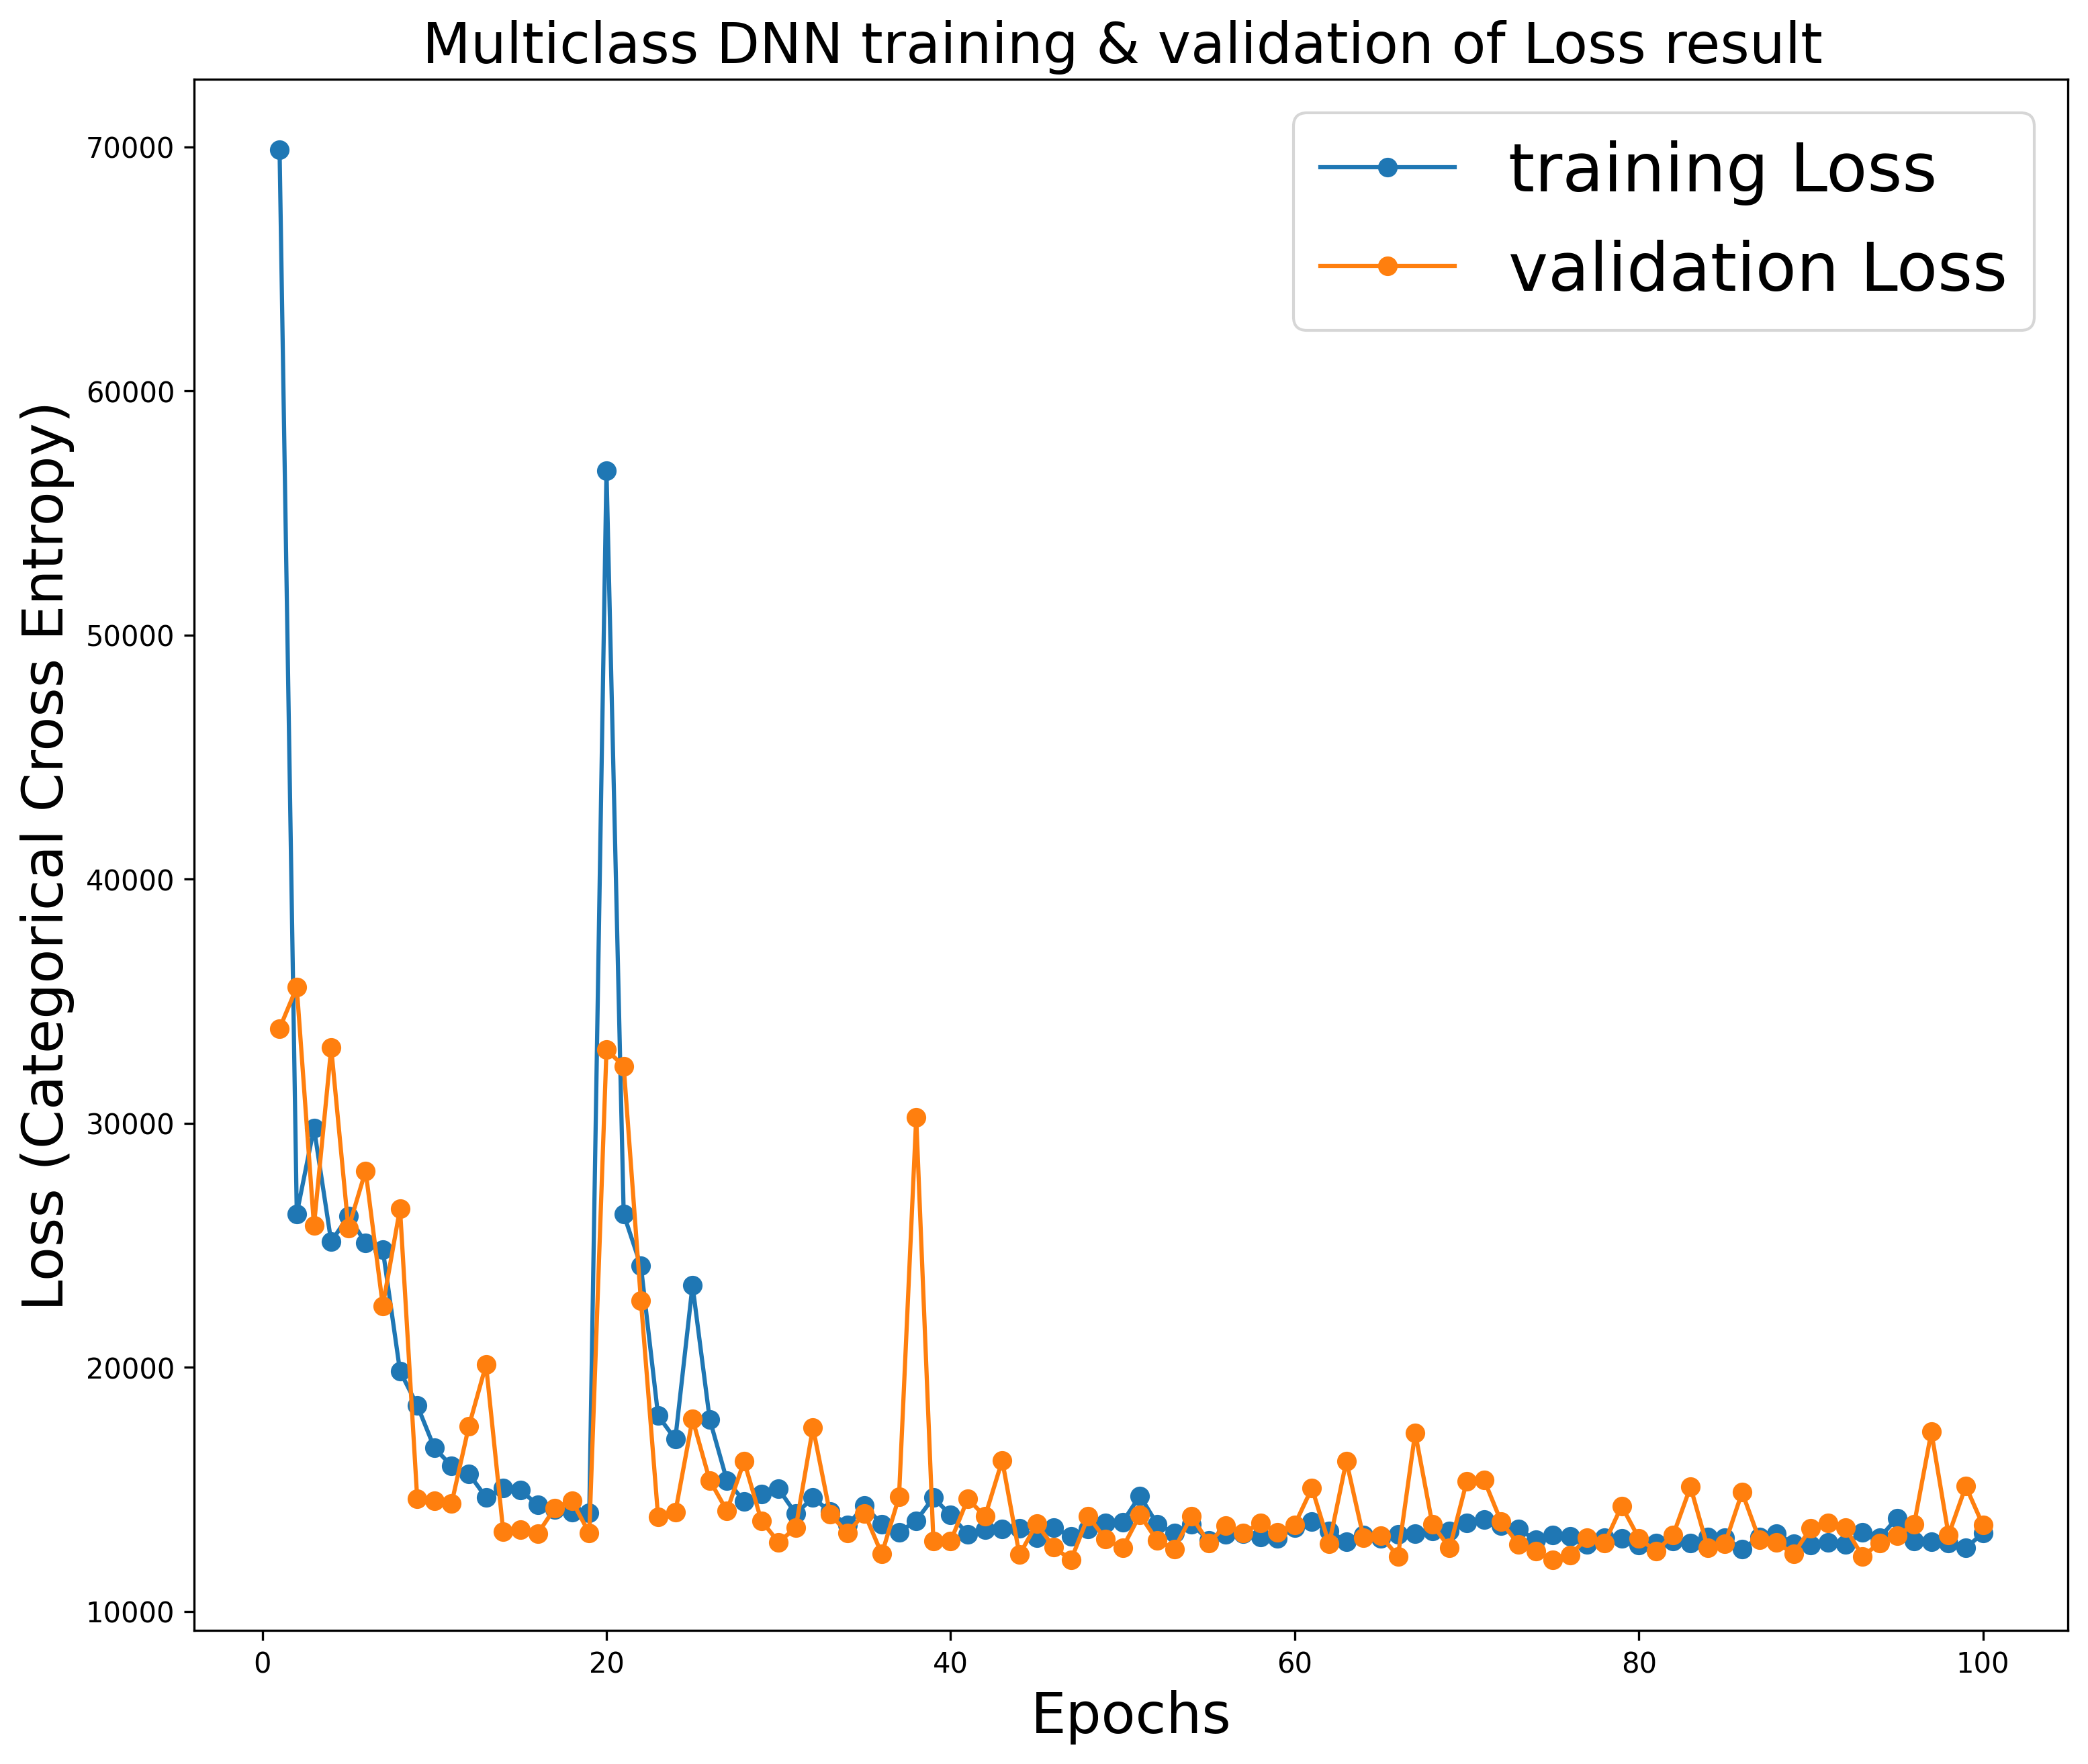

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.7)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 8s 50ms/step - loss: 66354.0625 - MAPE: 339.5253 - val_loss: 23654.1641 - val_MAPE: 101.3241
Epoch 2/100
48/48 [==============================] - 2s 34ms/step - loss: 23479.2246 - MAPE: 69.5238 - val_loss: 23251.9688 - val_MAPE: 52.3134
Epoch 3/100
48/48 [==============================] - 1s 30ms/step - loss: 18447.5059 - MAPE: 52.3194 - val_loss: 14845.3906 - val_MAPE: 33.1483
Epoch 4/100
48/48 [==============================] - 1s 31ms/step - loss: 22983.9766 - MAPE: 63.7121 - val_loss: 20448.0703 - val_MAPE: 82.9969
Epoch 5/100
48/48 [==============================] - 1s 30ms/step - loss: 16706.2656 - MAPE: 48.0896 - val_loss: 22596.3691 - val_MAPE: 60.9954
Epoch 6/100
48/48 [==============================] - 1s 30ms/step - loss: 17197.0547 - MAPE: 48.6062 - val_loss: 16608.3770 - val_MAPE: 42.6744
Epoch 7/100
48/48 [==============================] - 1s 31ms/step - loss: 18719.8633 - MAPE: 53.1089 - val_loss: 15239.7881 - val_MAPE

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

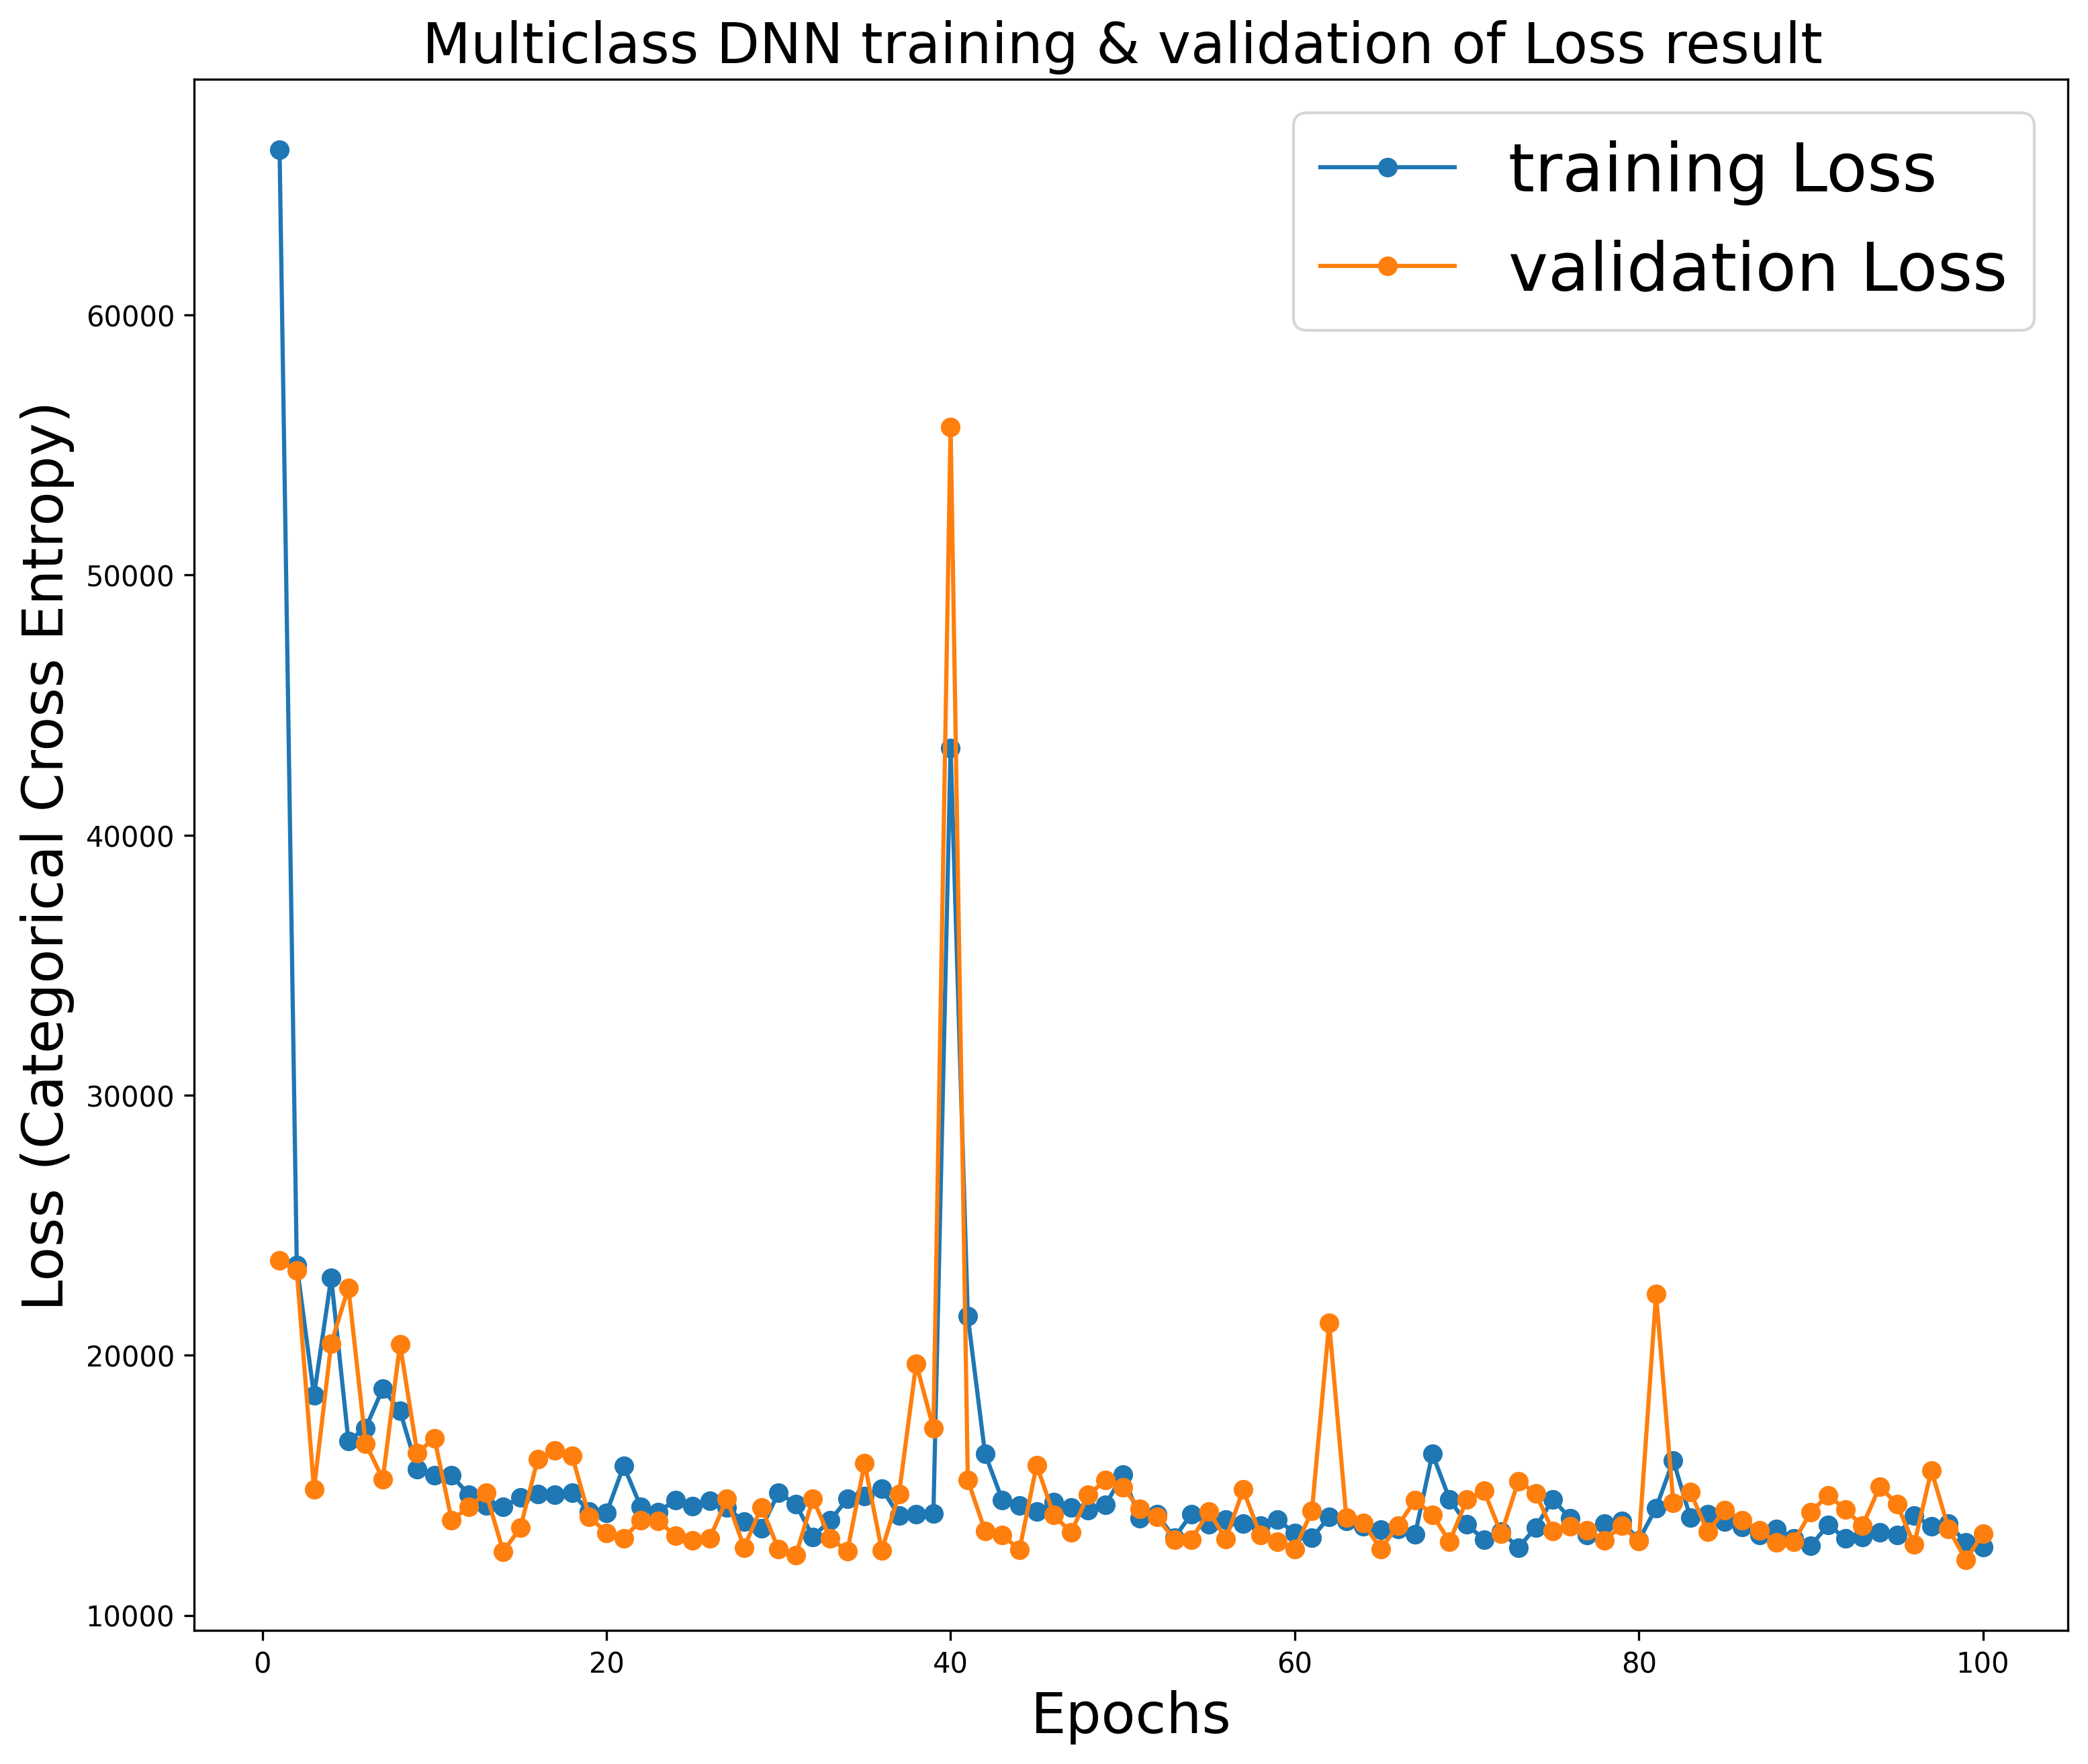

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.5)) #0.2 drop 

# 6.5 Add 4 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 35ms/step - loss: 41189.7461 - MAPE: 189.4274 - val_loss: 24018.7500 - val_MAPE: 59.7004
Epoch 2/100
48/48 [==============================] - 1s 30ms/step - loss: 21720.3574 - MAPE: 62.0688 - val_loss: 21078.7637 - val_MAPE: 42.4829
Epoch 3/100
48/48 [==============================] - 1s 30ms/step - loss: 19449.5918 - MAPE: 56.9234 - val_loss: 18265.5000 - val_MAPE: 43.8240
Epoch 4/100
48/48 [==============================] - 2s 32ms/step - loss: 18902.8789 - MAPE: 54.4636 - val_loss: 14783.6240 - val_MAPE: 48.2889
Epoch 5/100
48/48 [==============================] - 2s 31ms/step - loss: 15974.9326 - MAPE: 46.4654 - val_loss: 17439.4043 - val_MAPE: 37.2477
Epoch 6/100
48/48 [==============================] - 2s 31ms/step - loss: 15966.4707 - MAPE: 47.2429 - val_loss: 15942.3984 - val_MAPE: 35.5999
Epoch 7/100
48/48 [==============================] - 1s 31ms/step - loss: 15357.0117 - MAPE: 44.3497 - val_loss: 18953.1875 - val_MAPE:

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

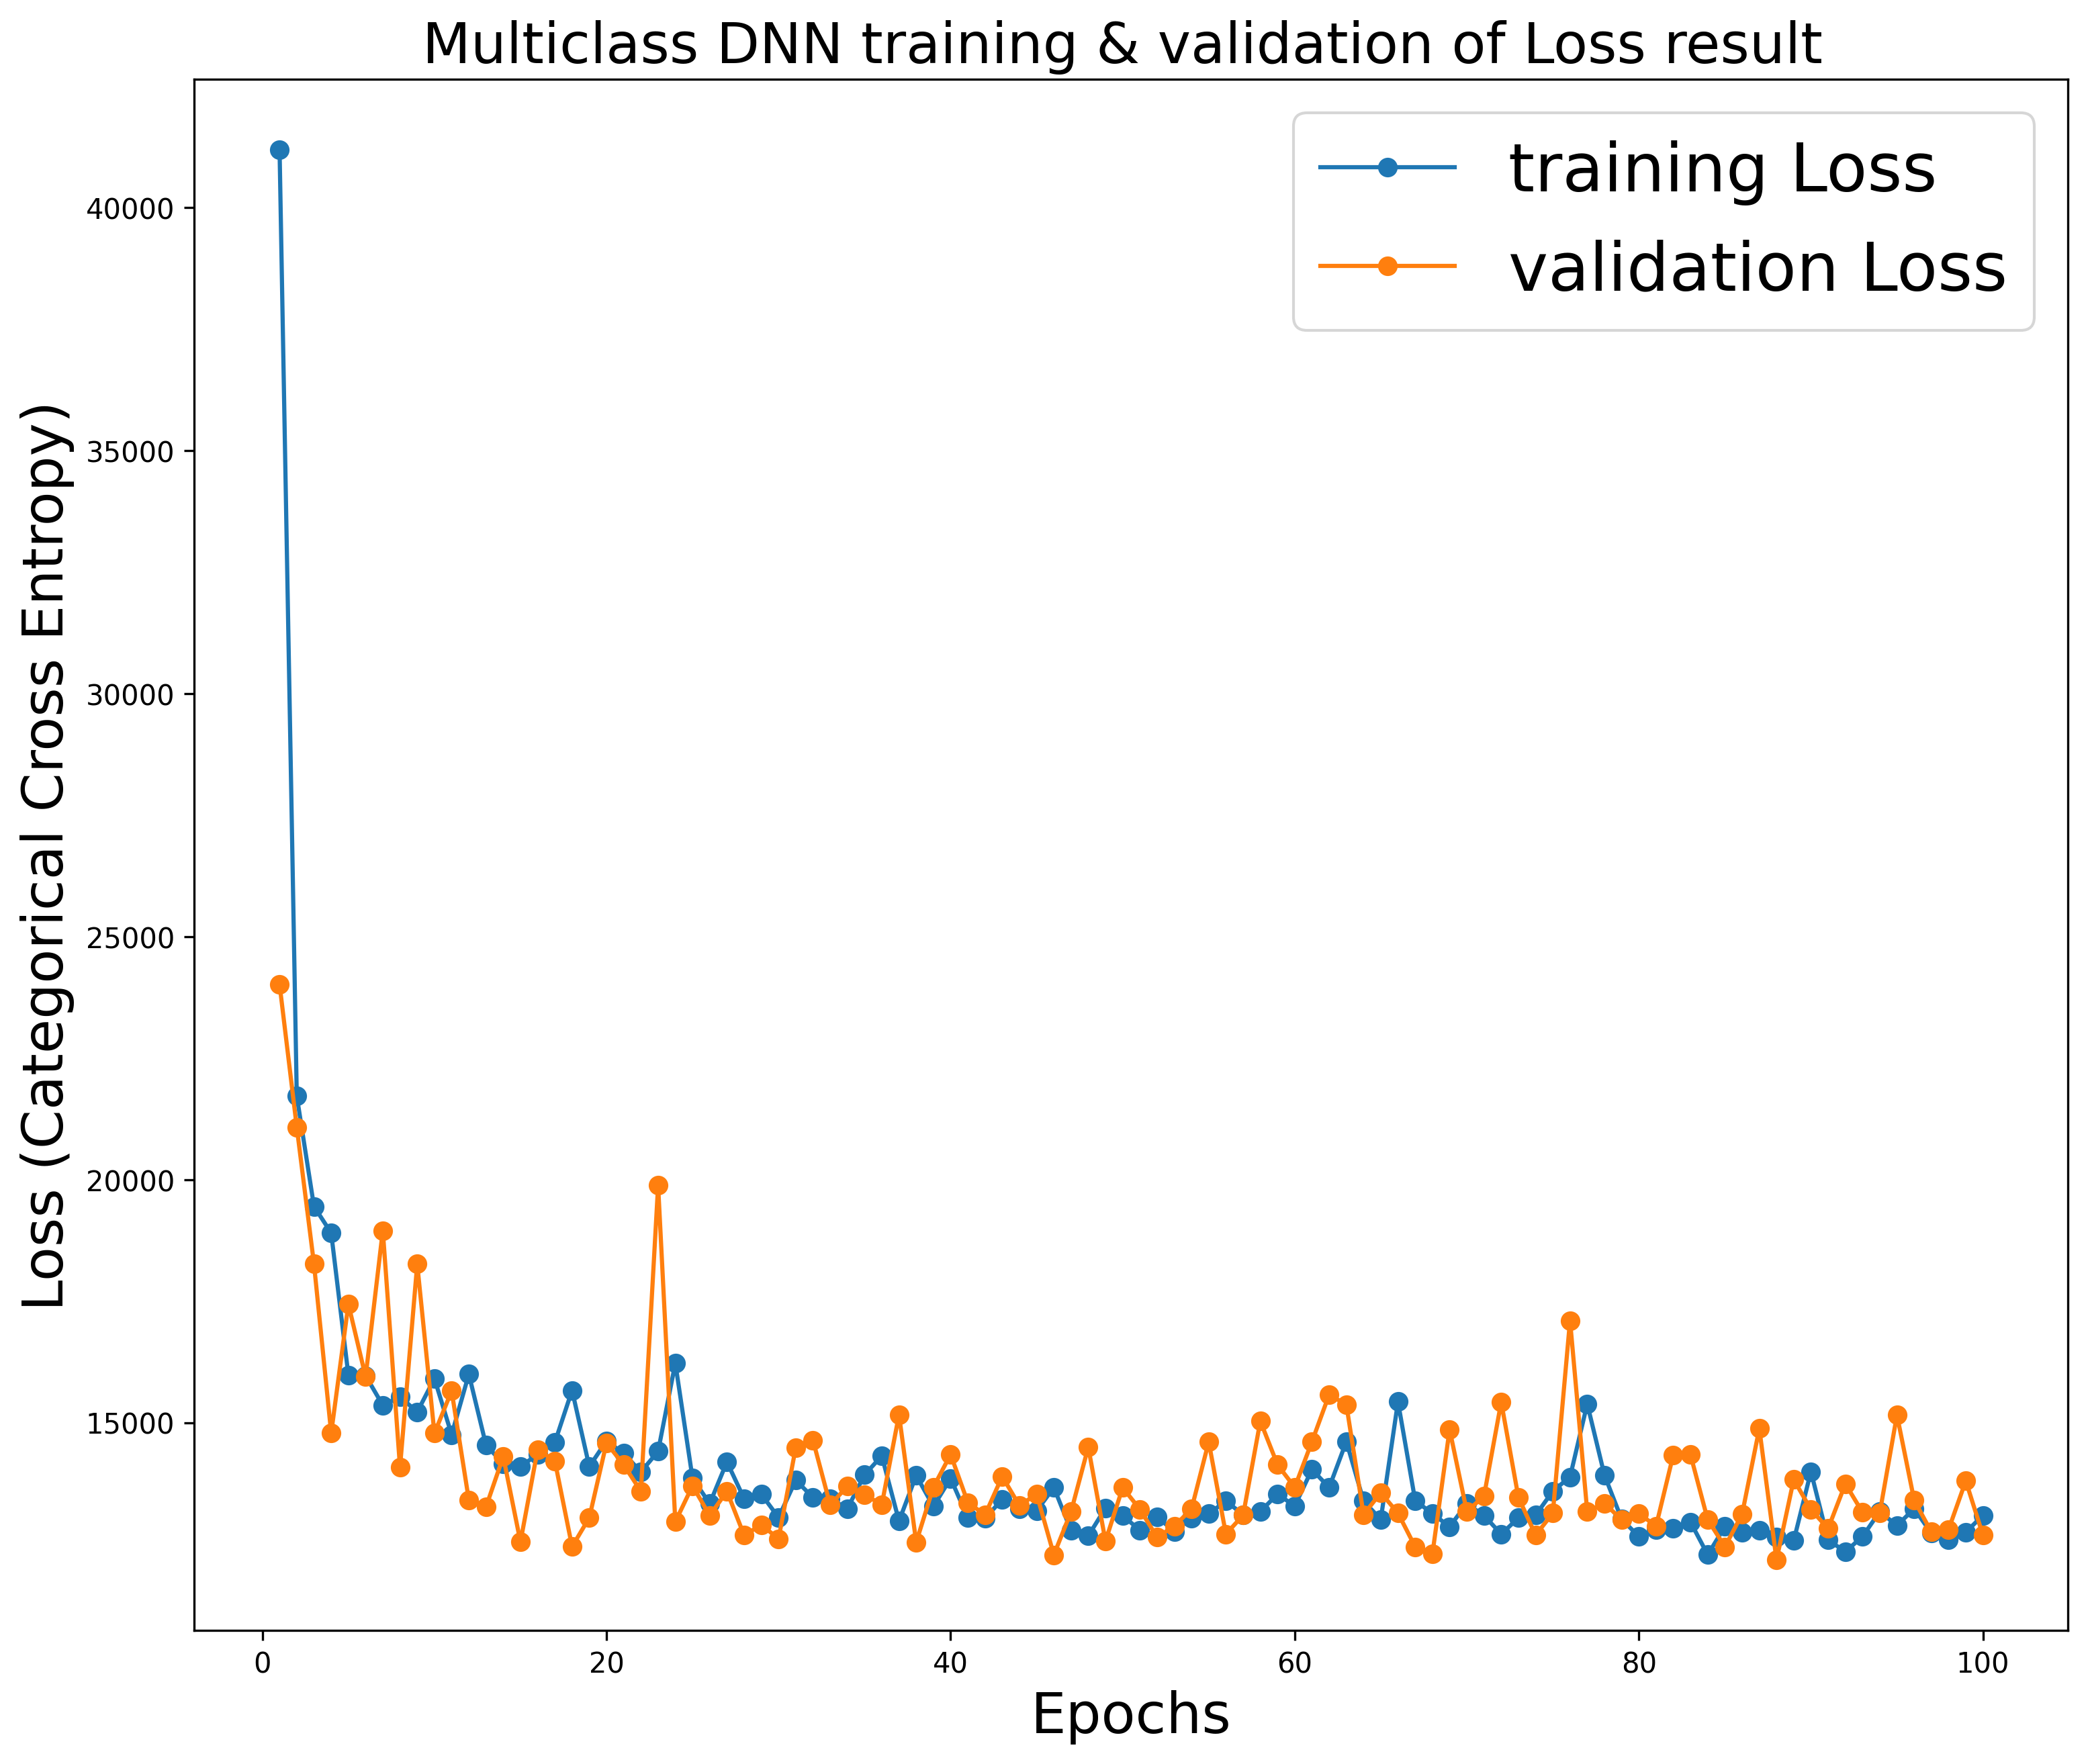

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

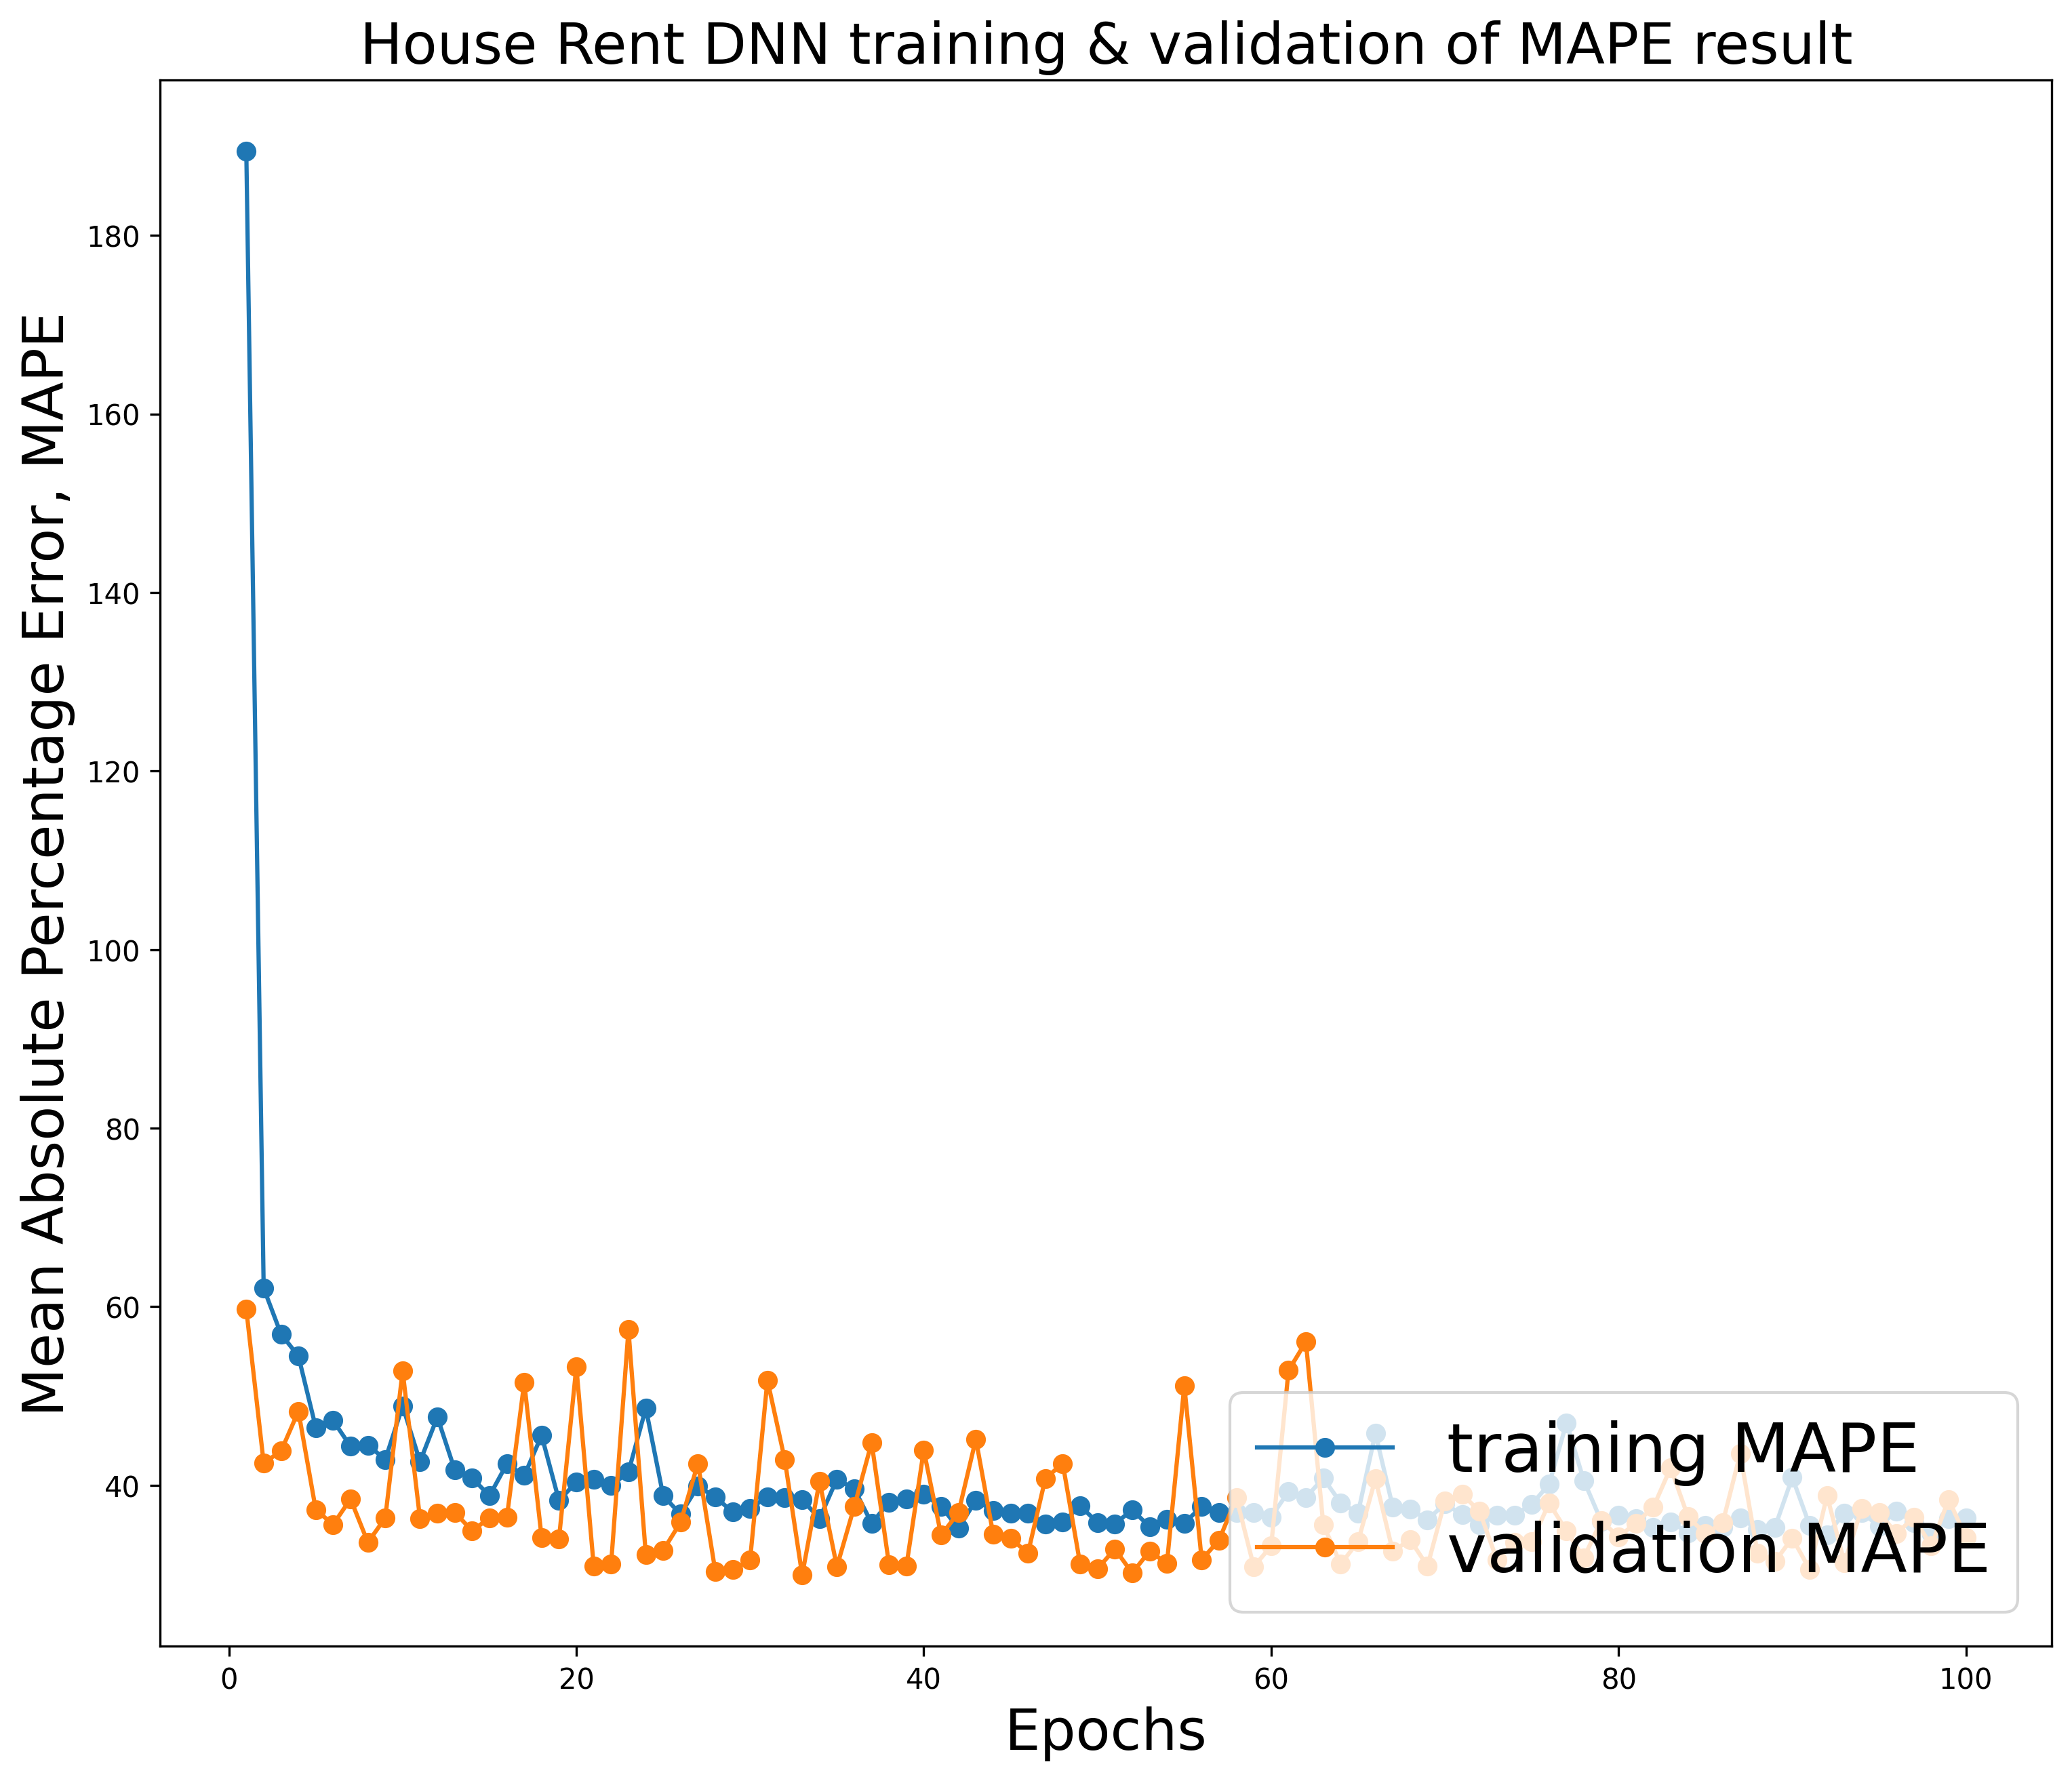

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['MAPE']
val_acc_values=modeling_result['val_MAPE']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('House Rent DNN training & validation of MAPE result',fontsize=20)

plt.plot(epochs, training_acc_values,marker='o',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='o',label='validation MAPE')
plt.legend(loc=4,fontsize=24)
plt.show()

In [ ]:
# 7.3 Save the trained model
#model.save('D:/data_analysis/PyExport/Multiclass_ANN_trained_model.h5')
# Colab
model.save('Multiclass_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Multiclass_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/Multiclass_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


In [ ]:
# 8.1 Make prediction #轉成一維
prediction=np.round(DNN_model.predict_on_batch(x_test),0)
prediction=prediction.astype('int')
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Num':range(1,len(prediction)+1),'Y_true':y_test,'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

Num  Y_true  Predict  abs Error
526     1   45000    28889      16111
2394    2   90000    63335      26665
1790    3   17000    11991       5009
1225    4   21000    33300      12300
3668    5   18000    14881       3119
...   ...     ...      ...        ...
4707  946   25000    11297      13703
4393  947   13000    21585       8585
2345  948   11000     9510       1490
3675  949    8200    13516       5316
1028  950   65000    44414      20586

[950 rows x 4 columns]

In [ ]:
MAE=mean_absolute_error(y_test,pred_values)
MSE=mean_squared_error(y_test,pred_values,squared=True)
RMSE=mean_squared_error(y_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_test,pred_values)
SMAPE=SMAPE_calulate(y_test,pred_values)
RAE=RAE_calculate(y_test,pred_values)
MRAE=MRAE_calculate(y_test,pred_values)
MdRAE=MdRAE_calculate(y_test,pred_values)
RSE=RSE_calculate(y_test,pred_values,Root=False)
RRSE=RSE_calculate(y_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 10861.201
MSE: 737129258.106
RMSE: 27150.124
MAPE: 33.088 %
SMAPE: 30.567 %
RAE: 0.417
MRAE: 0.00043861969861728225
MdRAE: 0.224 bench: 31476.68
RSE: 0.334
RRSE: 0.578


In [ ]:
# Figure setting
plt.figure(figsize=(30,8),dpi=600)
plt.title('True value vs Predict value',weight='bold',fontsize=36)
plt.xlabel('Observations',fontsize=24,weight='bold')
plt.ylabel('Value',fontsize=24,weight='bold')

# Scatter plot
plt.scatter(Results.iloc[:,0],Results.iloc[:,1],color='blue',label='Y_true')
plt.scatter(Results.iloc[:,0],Results.iloc[:,2],color='red',label='Y_pred')

# Figure setting
plt.legend(loc=1,fontsize=24)
# Set x-axis to let the plot looks nice
plt.xlim(-50,1000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

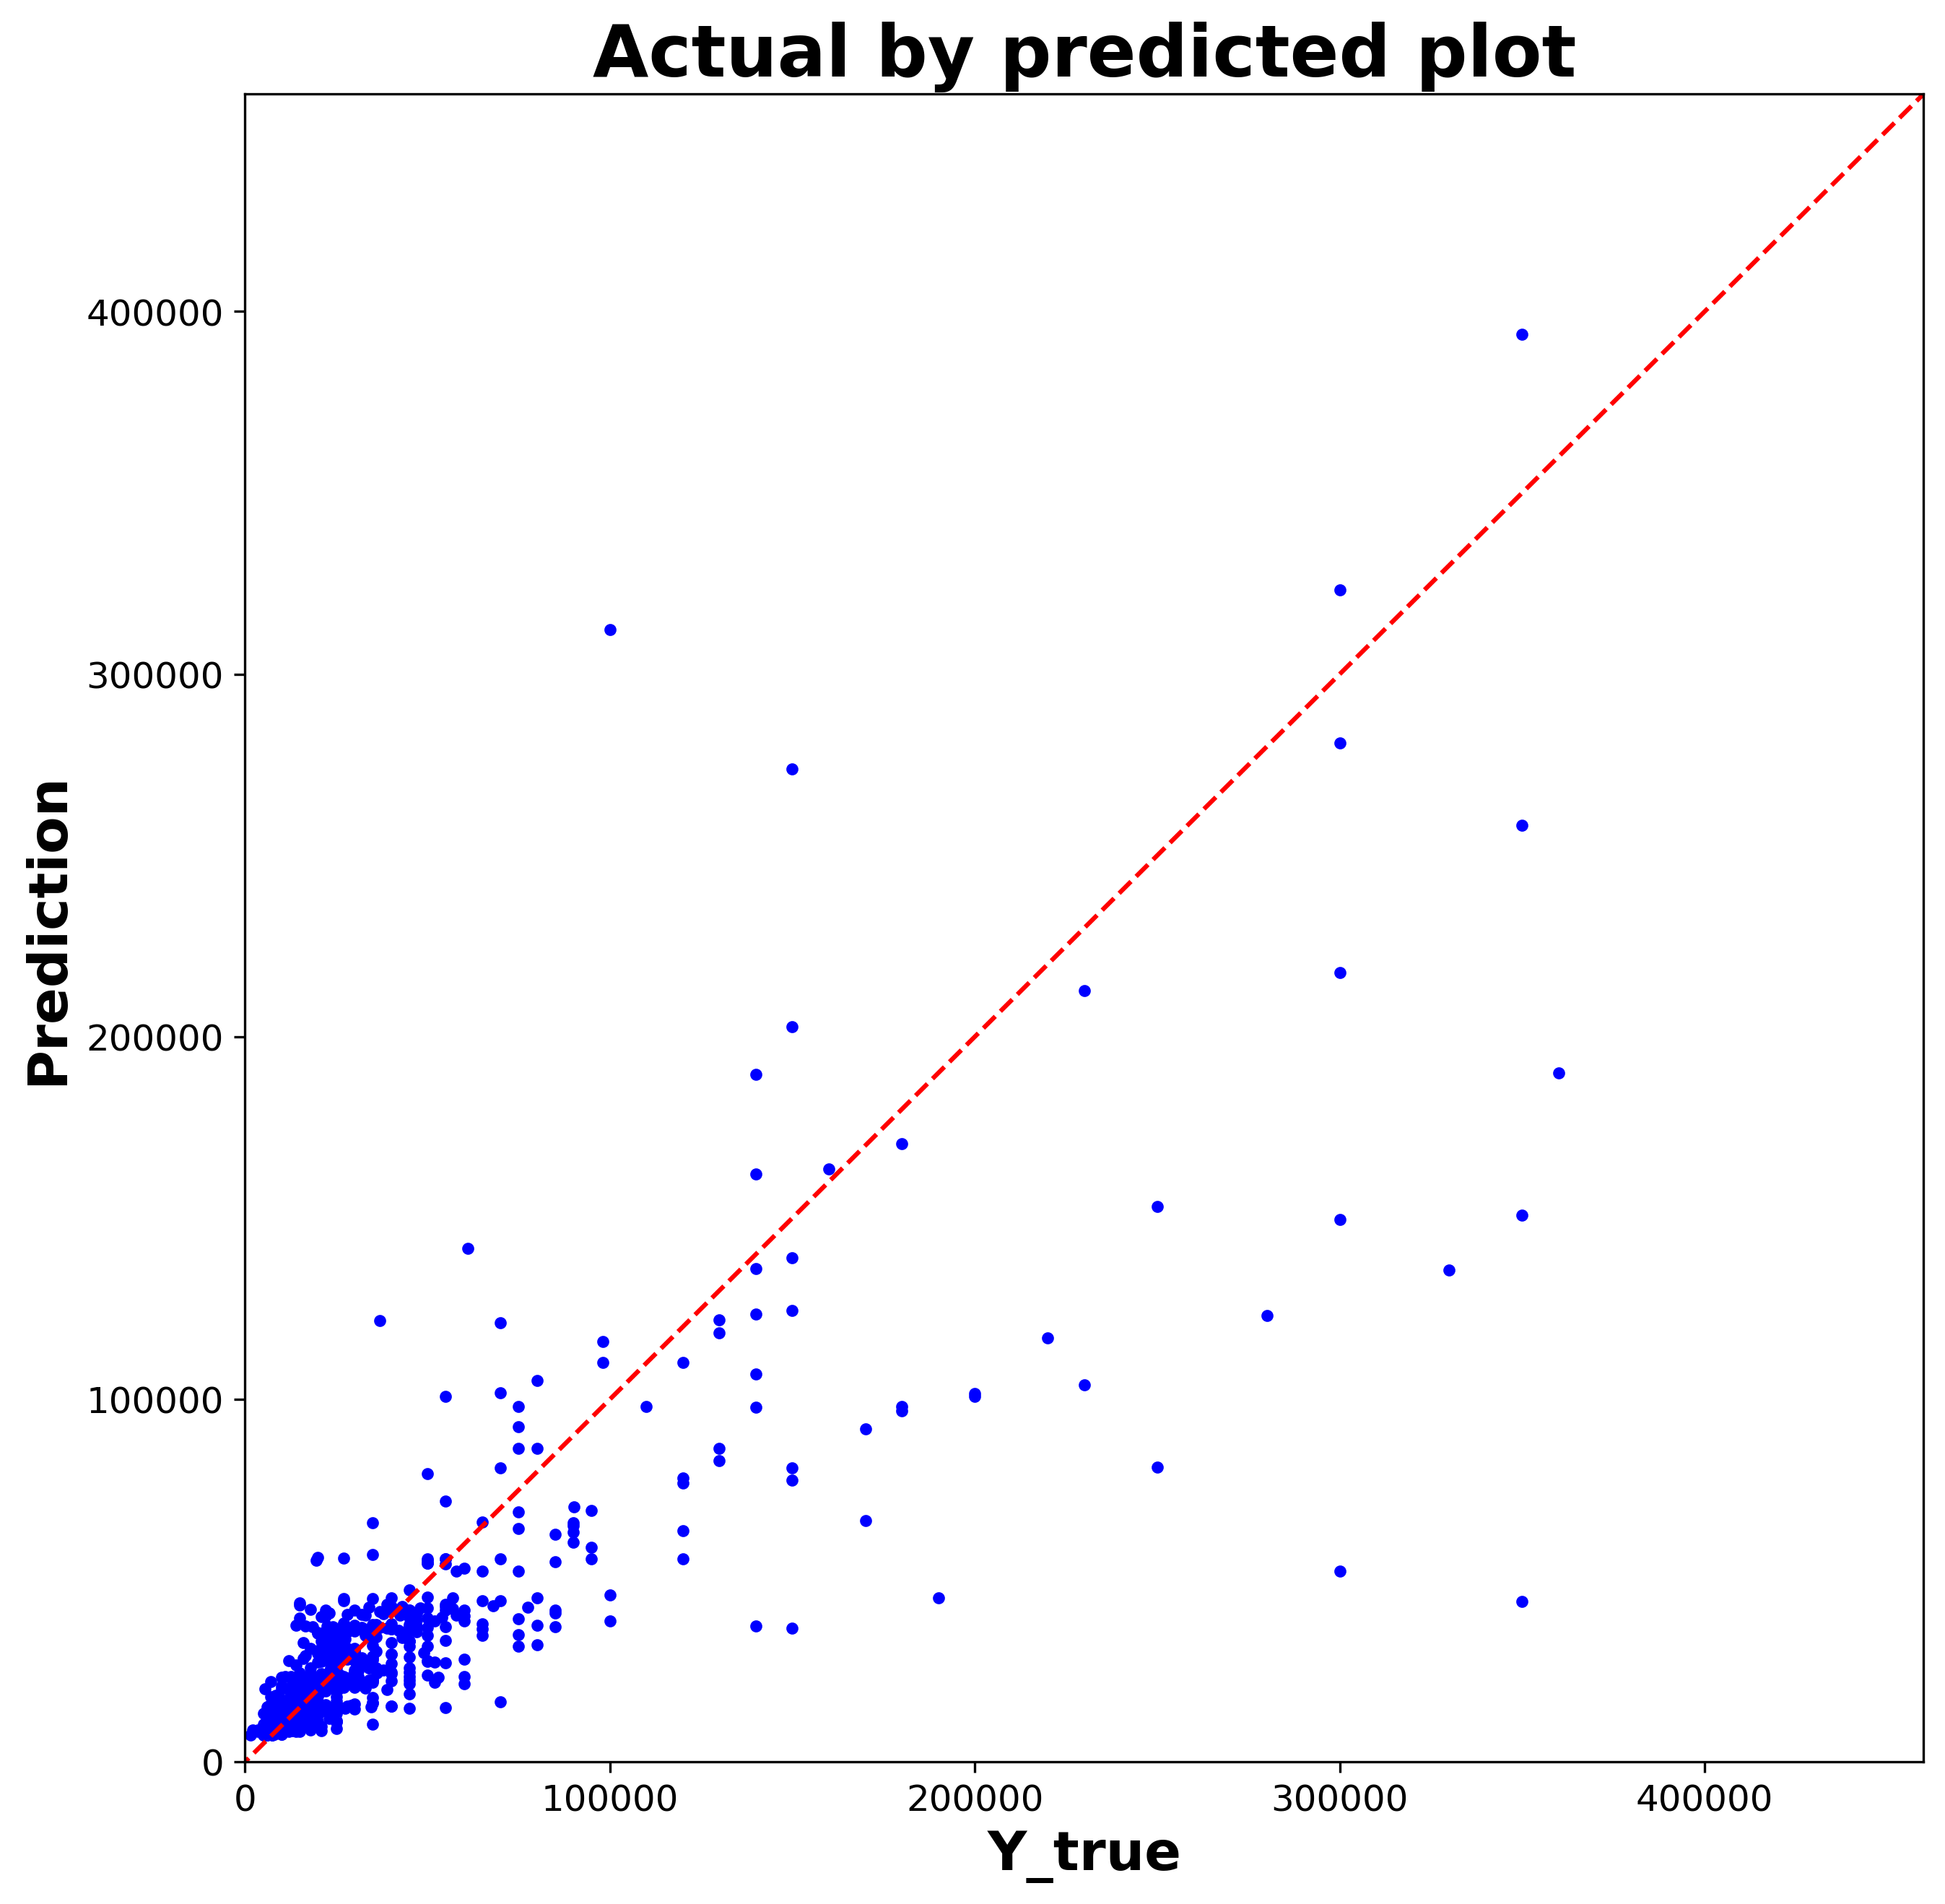

In [ ]:
# Lock the scale of axis by Y_true
max_value=max(y_test)+100000 #鎖死值域
min_value=min(y_test)-100000

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Y_true',fontsize=18,weight='bold')
plt.ylabel('Prediction',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0,max_value)
plt.xlim(0,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [22]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,4,24)
model.add(Dense(units=768,activation='linear'))
# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.1 drop 

# 6.5 Add 4 more dense layers
dense_generator(model,3,768)
model.add(Dense(units=12288,activation='softmax'))
# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.01,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [23]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 35ms/step - loss: 35337.7695 - MAPE: 99.9967 - val_loss: 38011.1719 - val_MAPE: 99.9931
Epoch 2/100
48/48 [==============================] - 1s 30ms/step - loss: 35336.7695 - MAPE: 99.9894 - val_loss: 38010.1719 - val_MAPE: 99.9860
Epoch 3/100
48/48 [==============================] - 1s 30ms/step - loss: 35335.7852 - MAPE: 99.9823 - val_loss: 38009.1953 - val_MAPE: 99.9791
Epoch 4/100
48/48 [==============================] - 1s 30ms/step - loss: 35334.8047 - MAPE: 99.9753 - val_loss: 38008.2227 - val_MAPE: 99.9722
Epoch 5/100
48/48 [==============================] - 1s 31ms/step - loss: 35333.8320 - MAPE: 99.9683 - val_loss: 38007.2500 - val_MAPE: 99.9653
Epoch 6/100
48/48 [==============================] - 2s 33ms/step - loss: 35332.8633 - MAPE: 99.9613 - val_loss: 38006.2852 - val_MAPE: 99.9584
Epoch 7/100
48/48 [==============================] - 1s 31ms/step - loss: 35331.8945 - MAPE: 99.9543 - val_loss: 38005.3125 - val_MAPE: 

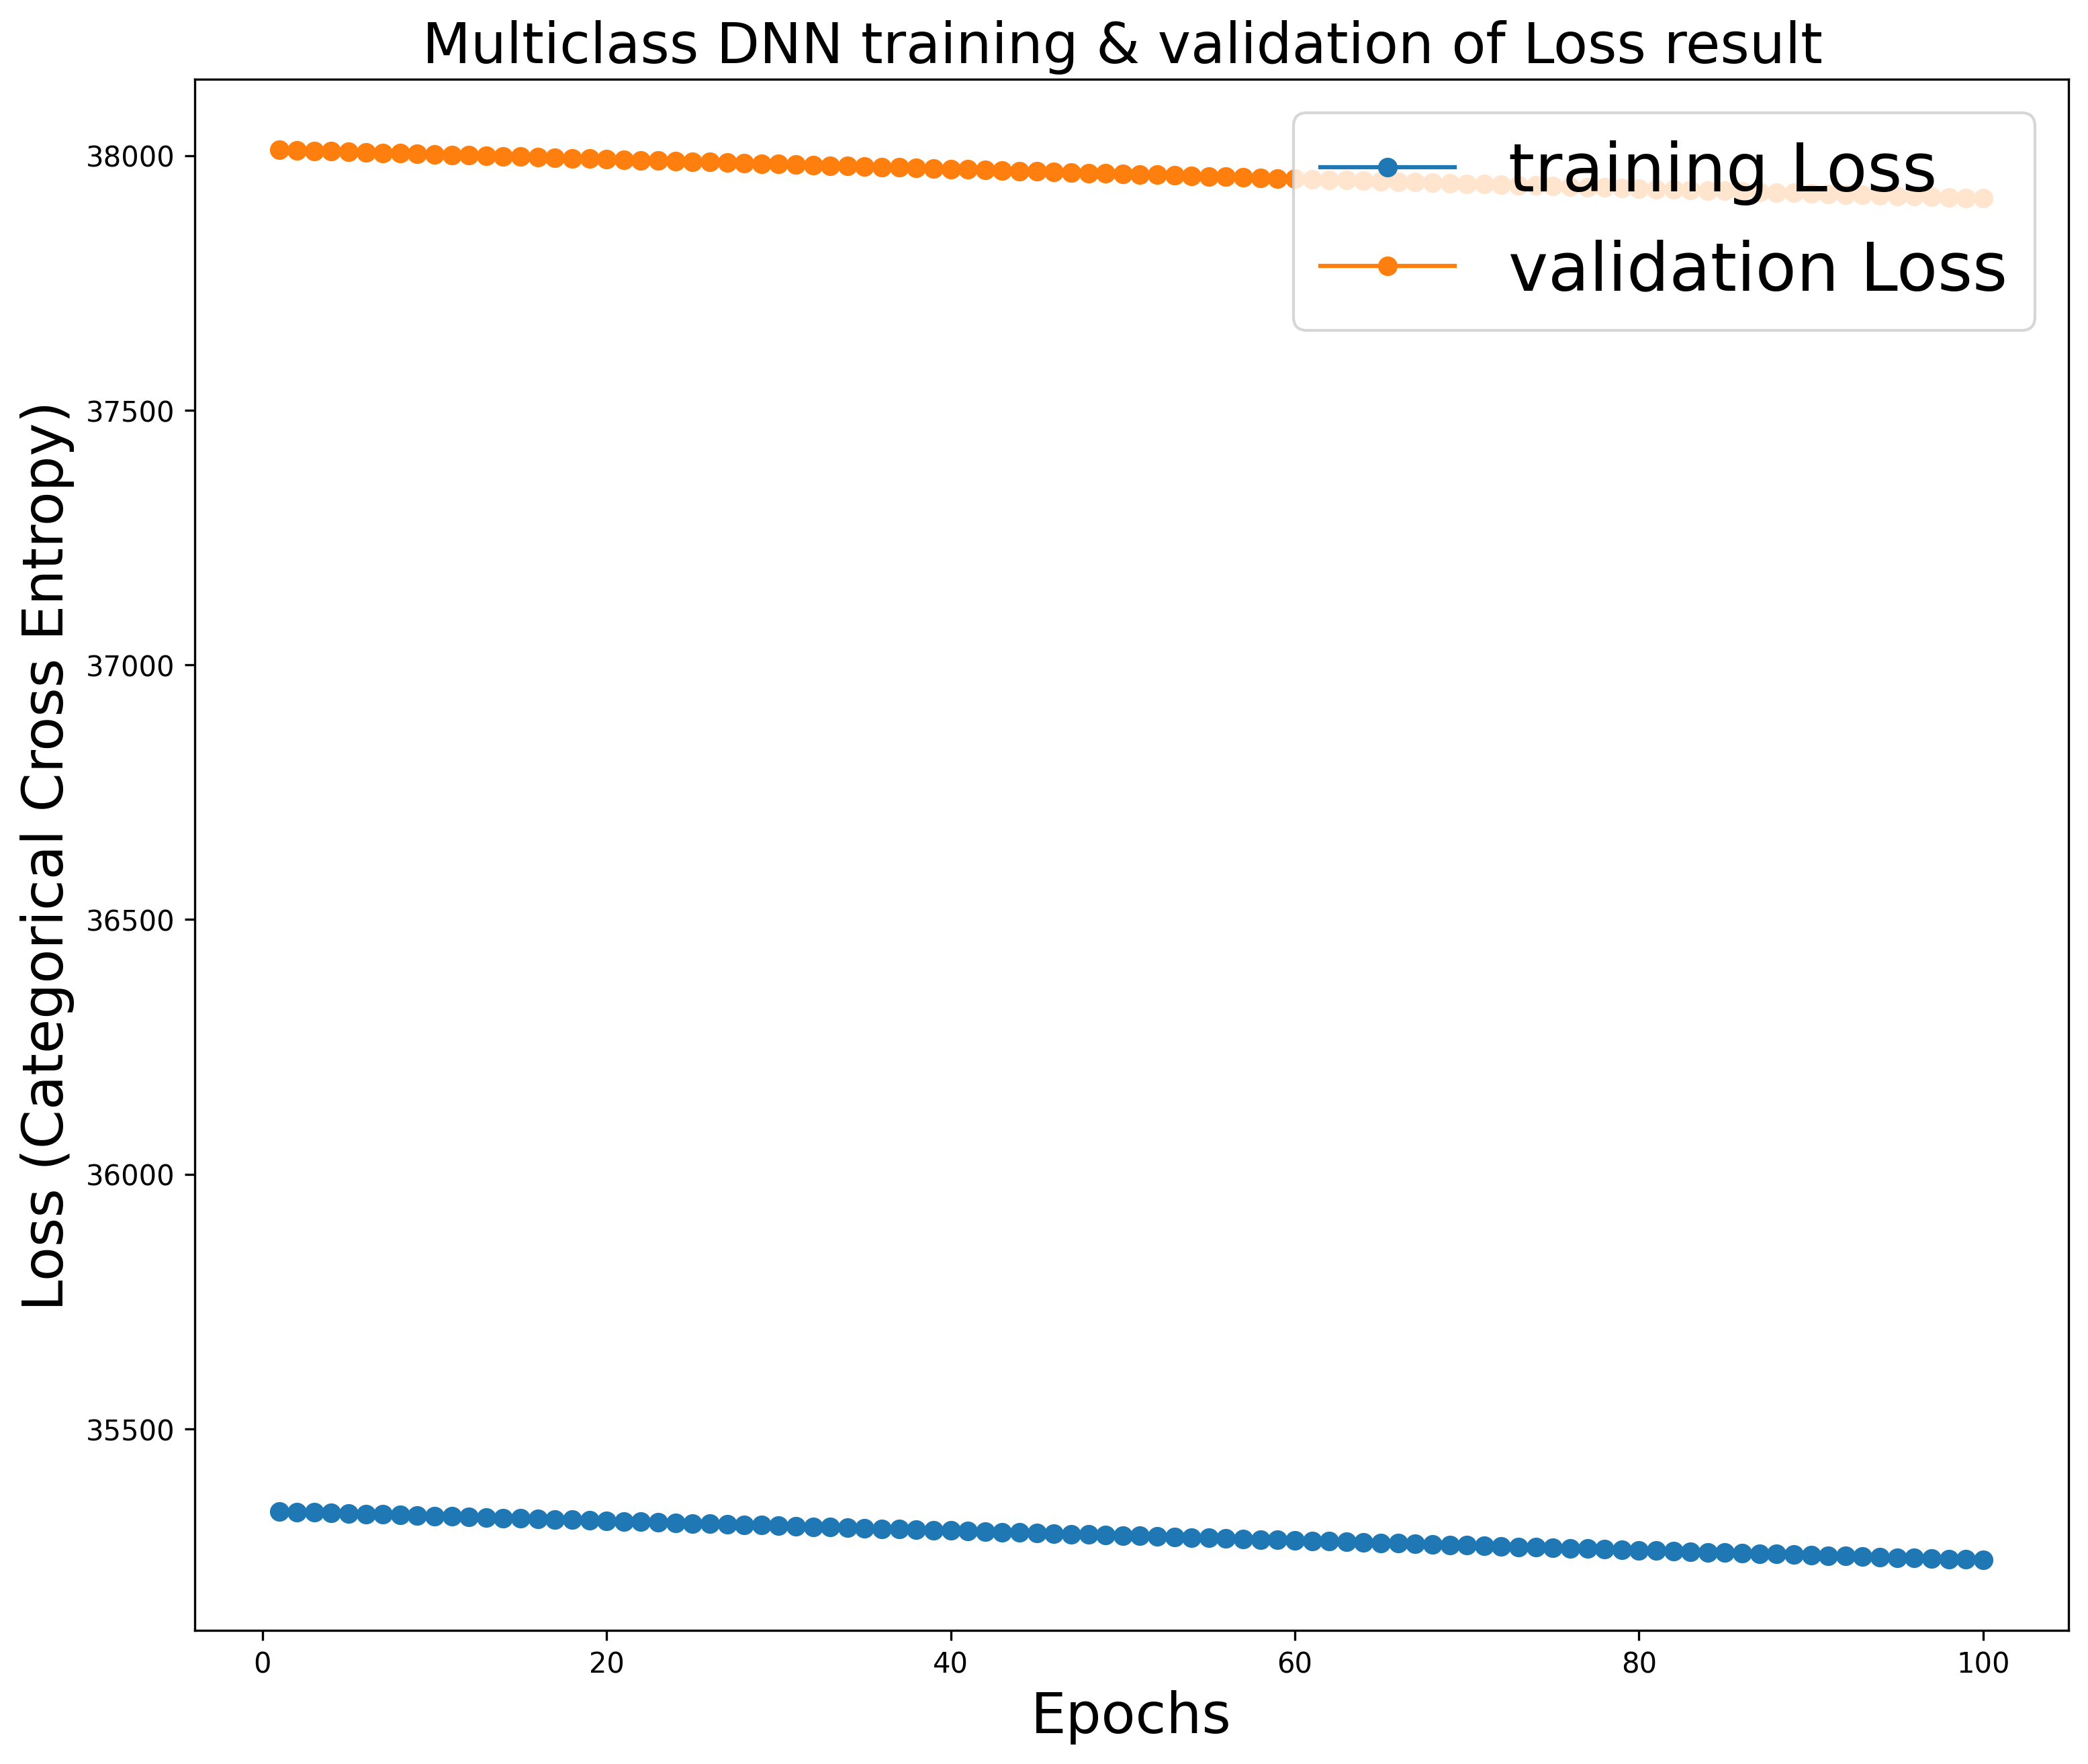

In [24]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['MAPE']
val_acc_values=modeling_result['val_MAPE']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('House Rent DNN training & validation of MAPE result',fontsize=20)

plt.plot(epochs, training_acc_values,marker='o',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='o',label='validation MAPE')
plt.legend(loc=4,fontsize=24)
plt.show()

In [ ]:
# 7.3 Save the trained model
#model.save('D:/data_analysis/PyExport/Multiclass_ANN_trained_model.h5')
# Colab
model.save('Multiclass_ANN_trained_model.h5')
print('Model has been saved...')

In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Multiclass_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/Multiclass_ANN_trained_model.h5')
print('Model successfully loaded...')

In [ ]:
# 8.1 Make prediction #轉成一維
prediction=np.round(DNN_model.predict_on_batch(x_test),0)
prediction=prediction.astype('int')
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Num':range(1,len(prediction)+1),'Y_true':y_test,'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

In [ ]:
MAE=mean_absolute_error(y_test,pred_values)
MSE=mean_squared_error(y_test,pred_values,squared=True)
RMSE=mean_squared_error(y_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_test,pred_values)
SMAPE=SMAPE_calulate(y_test,pred_values)
RAE=RAE_calculate(y_test,pred_values)
MRAE=MRAE_calculate(y_test,pred_values)
MdRAE=MdRAE_calculate(y_test,pred_values)
RSE=RSE_calculate(y_test,pred_values,Root=False)
RRSE=RSE_calculate(y_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

In [ ]:
# Figure setting
plt.figure(figsize=(30,8),dpi=600)
plt.title('True value vs Predict value',weight='bold',fontsize=36)
plt.xlabel('Observations',fontsize=24,weight='bold')
plt.ylabel('Value',fontsize=24,weight='bold')

# Scatter plot
plt.scatter(Results.iloc[:,0],Results.iloc[:,1],color='blue',label='Y_true')
plt.scatter(Results.iloc[:,0],Results.iloc[:,2],color='red',label='Y_pred')

# Figure setting
plt.legend(loc=1,fontsize=24)
# Set x-axis to let the plot looks nice
plt.xlim(-50,1000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# Lock the scale of axis by Y_true
max_value=max(y_test)+100000 #鎖死值域
min_value=min(y_test)-100000

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Y_true',fontsize=18,weight='bold')
plt.ylabel('Prediction',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0,max_value)
plt.xlim(0,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 35ms/step - loss: 31425.5938 - MAPE: 104.5890 - val_loss: 20880.5156 - val_MAPE: 59.7051
Epoch 2/100
48/48 [==============================] - 1s 30ms/step - loss: 18715.6465 - MAPE: 55.3089 - val_loss: 18732.8691 - val_MAPE: 69.6102
Epoch 3/100
48/48 [==============================] - 1s 30ms/step - loss: 17520.8477 - MAPE: 51.1661 - val_loss: 13435.0771 - val_MAPE: 38.1147
Epoch 4/100
48/48 [==============================] - 1s 31ms/step - loss: 15256.7666 - MAPE: 42.1948 - val_loss: 13401.0029 - val_MAPE: 37.3040
Epoch 5/100
48/48 [==============================] - 1s 30ms/step - loss: 14563.9238 - MAPE: 38.6975 - val_loss: 12947.4844 - val_MAPE: 34.6461
Epoch 6/100
48/48 [==============================] - 2s 33ms/step - loss: 14996.7783 - MAPE: 43.0117 - val_loss: 13051.6660 - val_MAPE: 37.2174
Epoch 7/100
48/48 [==============================] - 2s 33ms/step - loss: 14165.7402 - MAPE: 38.9921 - val_loss: 12726.9180 - val_MAPE:

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

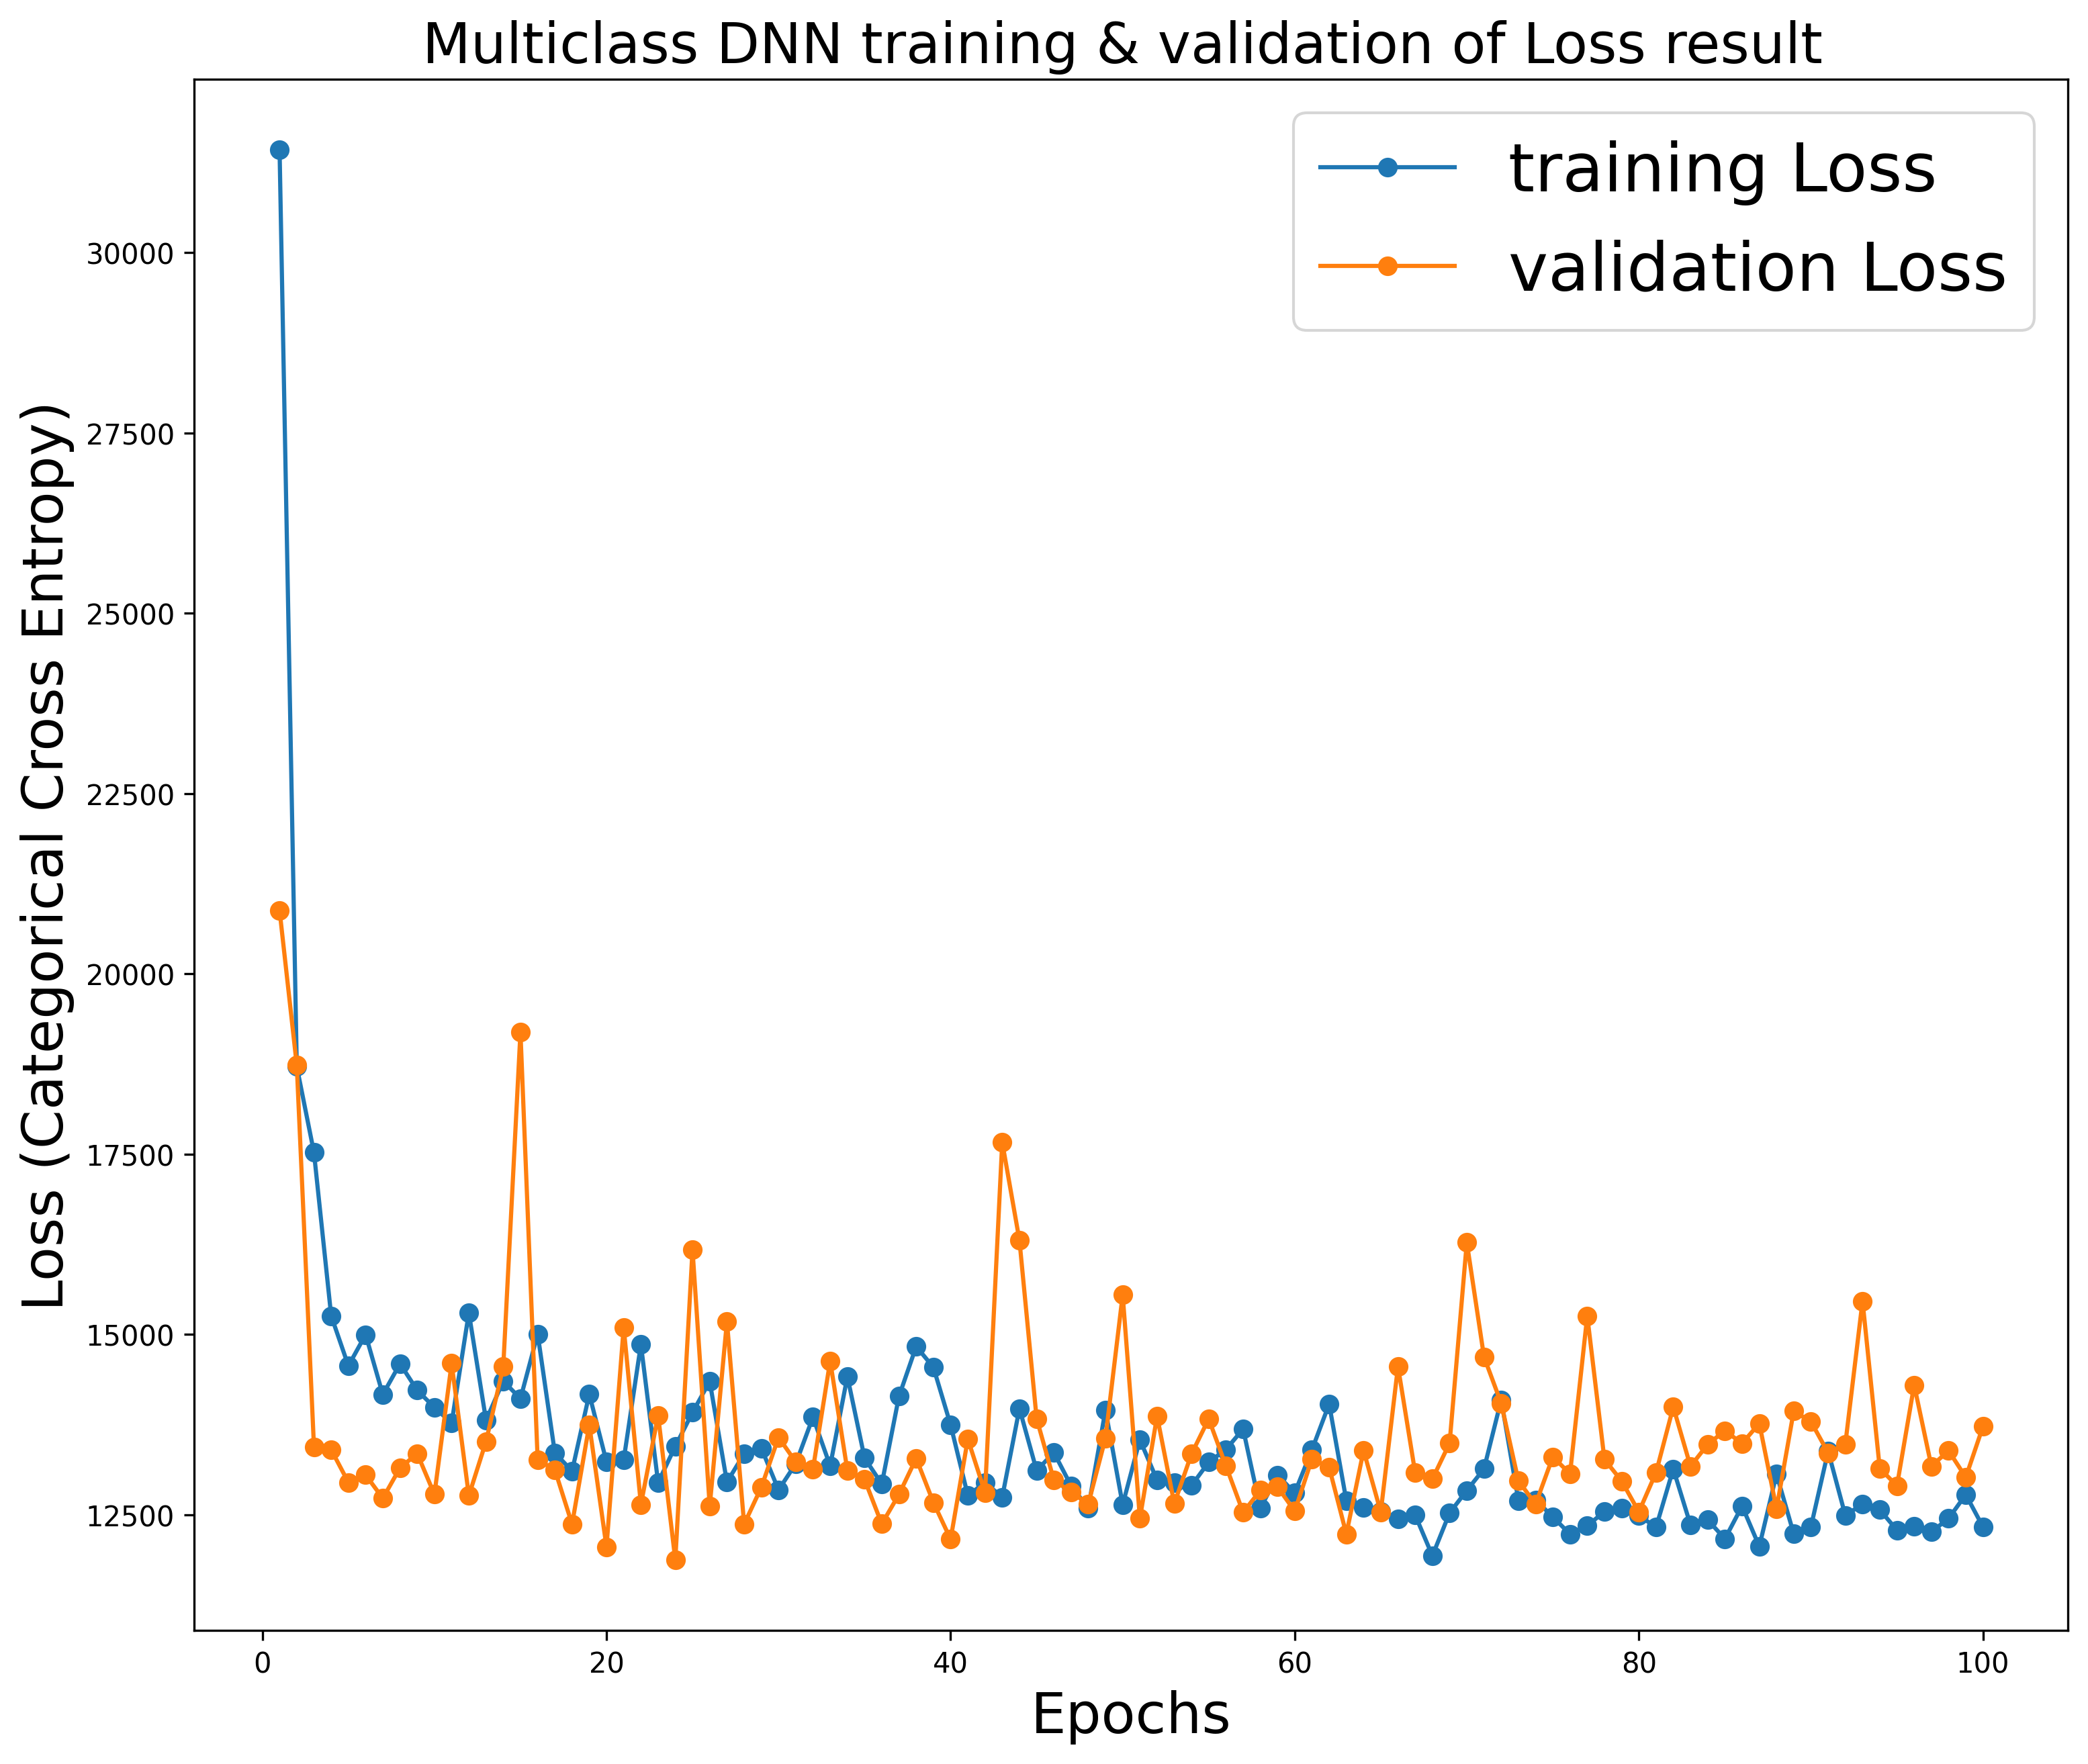

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.7)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 33ms/step - loss: 11923.3086 - MAPE: 34.4908 - val_loss: 16769.5996 - val_MAPE: 56.0978
Epoch 2/100
48/48 [==============================] - 1s 31ms/step - loss: 11805.2568 - MAPE: 33.8889 - val_loss: 17122.9863 - val_MAPE: 48.1046
Epoch 3/100
48/48 [==============================] - 1s 31ms/step - loss: 11657.5400 - MAPE: 33.3271 - val_loss: 14983.8975 - val_MAPE: 50.8450
Epoch 4/100
48/48 [==============================] - 1s 31ms/step - loss: 11872.1328 - MAPE: 34.2310 - val_loss: 14054.5684 - val_MAPE: 40.6912
Epoch 5/100
48/48 [==============================] - 1s 31ms/step - loss: 11940.1592 - MAPE: 34.0795 - val_loss: 15343.6602 - val_MAPE: 51.7349
Epoch 6/100
48/48 [==============================] - 2s 31ms/step - loss: 11575.8252 - MAPE: 33.0027 - val_loss: 14713.3818 - val_MAPE: 49.8712
Epoch 7/100
48/48 [==============================] - 2s 32ms/step - loss: 11500.4258 - MAPE: 33.5093 - val_loss: 12953.0498 - val_MAPE: 

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

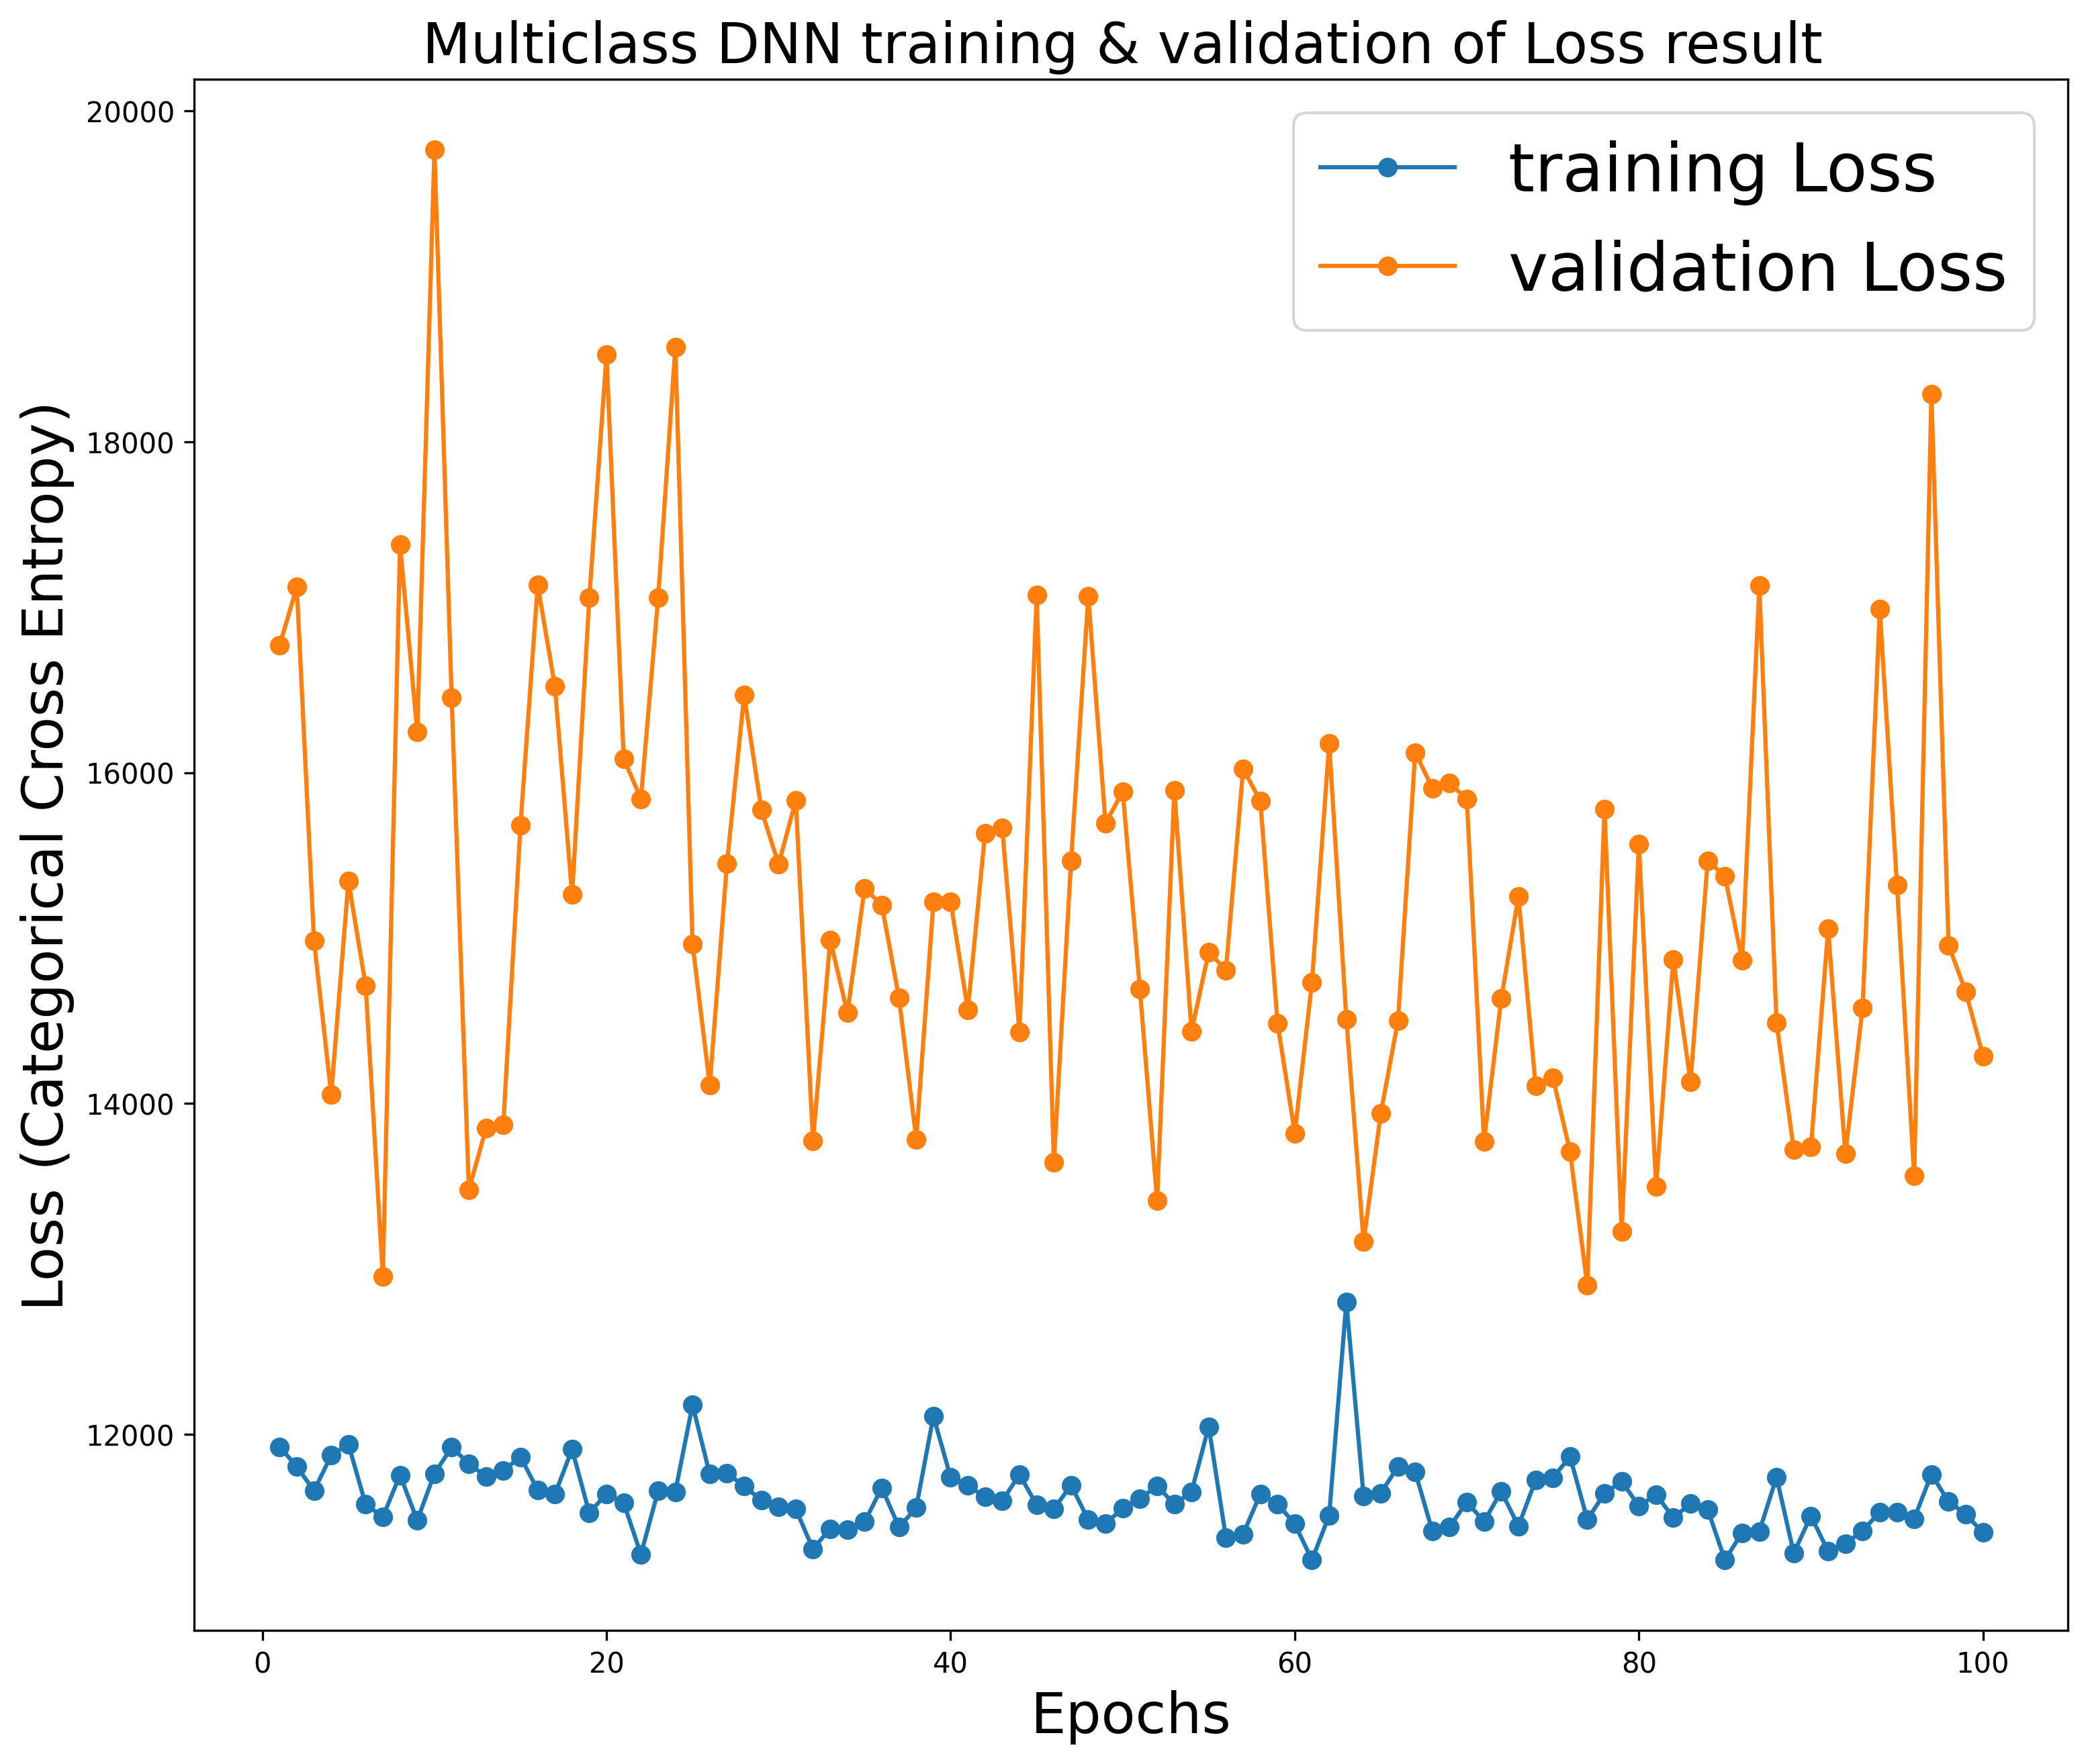

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.7)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 3s 39ms/step - loss: 24343.4570 - MAPE: 68.5838 - val_loss: 16447.6562 - val_MAPE: 40.5077
Epoch 2/100
48/48 [==============================] - 2s 33ms/step - loss: 17511.1367 - MAPE: 48.7310 - val_loss: 14427.8818 - val_MAPE: 33.5091
Epoch 3/100
48/48 [==============================] - 2s 32ms/step - loss: 17203.0820 - MAPE: 46.8450 - val_loss: 14191.5527 - val_MAPE: 56.0037
Epoch 4/100
48/48 [==============================] - 2s 32ms/step - loss: 15534.6689 - MAPE: 43.5954 - val_loss: 19185.3340 - val_MAPE: 81.3232
Epoch 5/100
48/48 [==============================] - 2s 32ms/step - loss: 15331.1992 - MAPE: 41.6772 - val_loss: 13294.4609 - val_MAPE: 33.1390
Epoch 6/100
48/48 [==============================] - 2s 31ms/step - loss: 14564.2266 - MAPE: 39.7182 - val_loss: 13127.9141 - val_MAPE: 41.8871
Epoch 7/100
48/48 [==============================] - 2s 32ms/step - loss: 14070.4326 - MAPE: 40.1852 - val_loss: 15719.1963 - val_MAPE: 

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

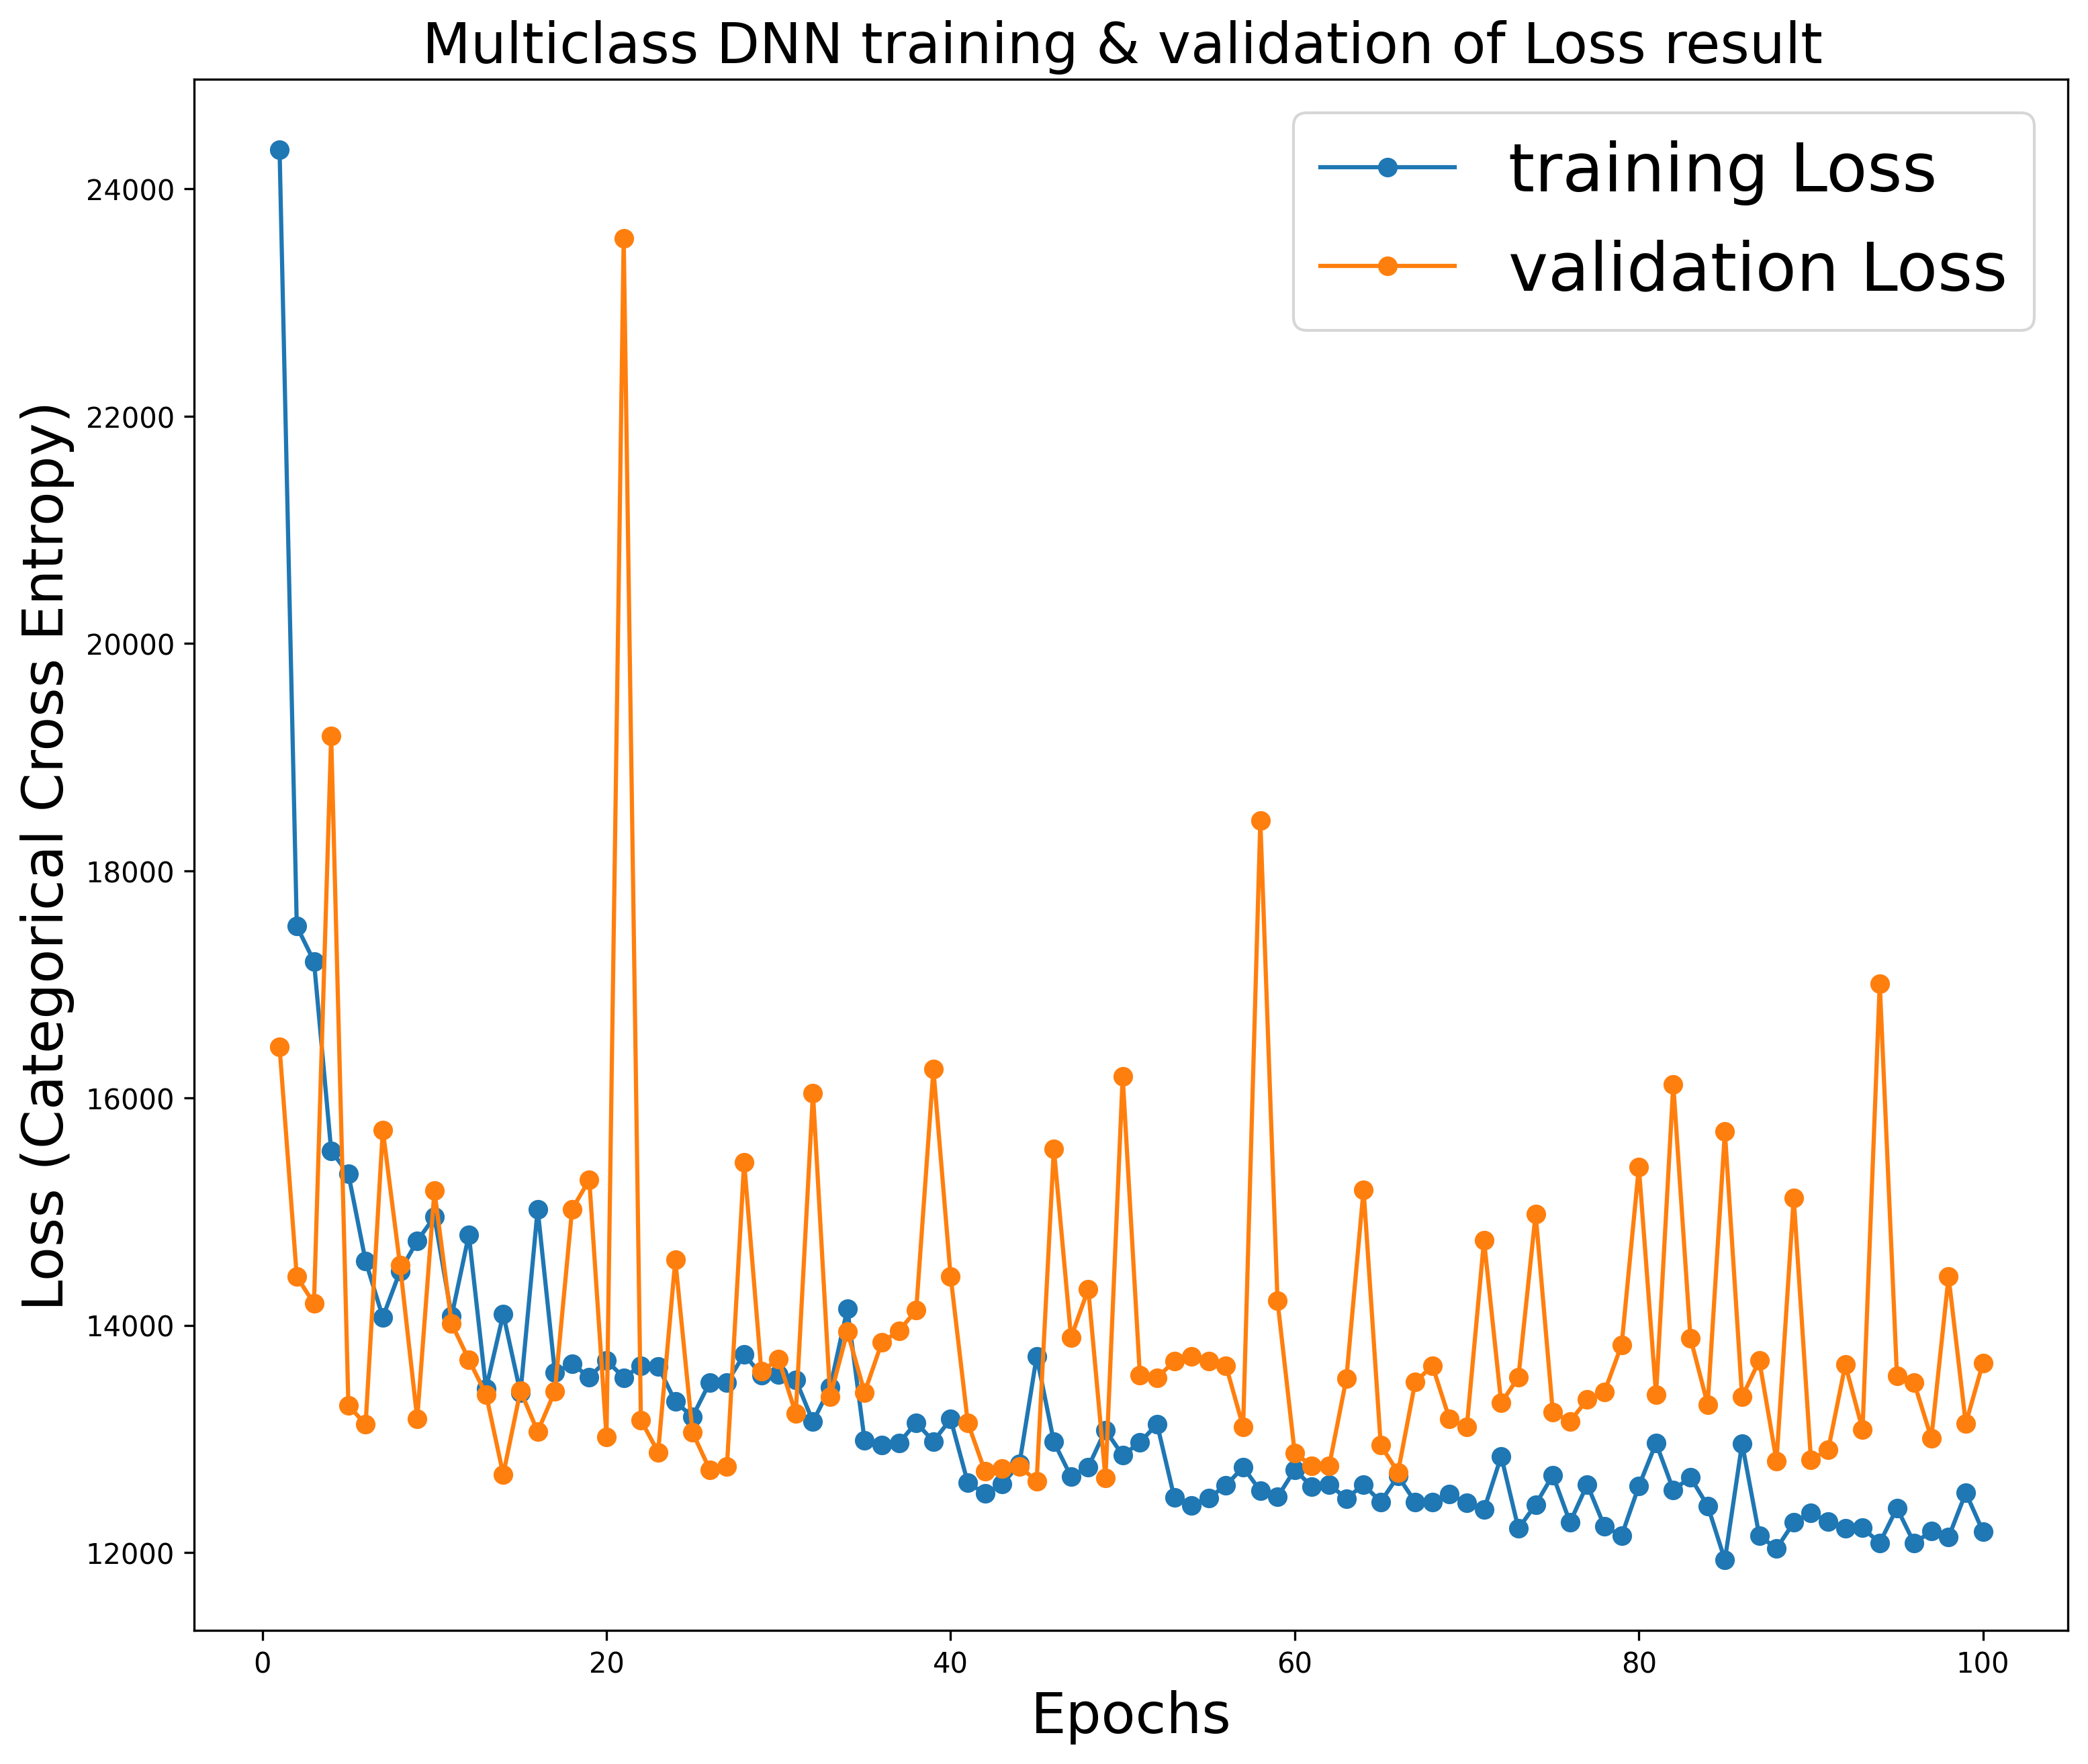

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 35ms/step - loss: 27186.8906 - MAPE: 76.8444 - val_loss: 24637.2129 - val_MAPE: 45.1978
Epoch 2/100
48/48 [==============================] - 1s 30ms/step - loss: 18928.9121 - MAPE: 49.7844 - val_loss: 15480.4580 - val_MAPE: 40.8885
Epoch 3/100
48/48 [==============================] - 1s 30ms/step - loss: 15304.9014 - MAPE: 41.5278 - val_loss: 14456.8037 - val_MAPE: 44.6626
Epoch 4/100
48/48 [==============================] - 1s 30ms/step - loss: 16398.8770 - MAPE: 46.6673 - val_loss: 14731.1553 - val_MAPE: 35.5826
Epoch 5/100
48/48 [==============================] - 1s 30ms/step - loss: 15524.2822 - MAPE: 42.7556 - val_loss: 13475.1982 - val_MAPE: 35.4521
Epoch 6/100
48/48 [==============================] - 1s 31ms/step - loss: 15042.4570 - MAPE: 41.1914 - val_loss: 14197.4541 - val_MAPE: 34.8735
Epoch 7/100
48/48 [==============================] - 2s 32ms/step - loss: 15528.5771 - MAPE: 43.0019 - val_loss: 14968.0381 - val_MAPE: 

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

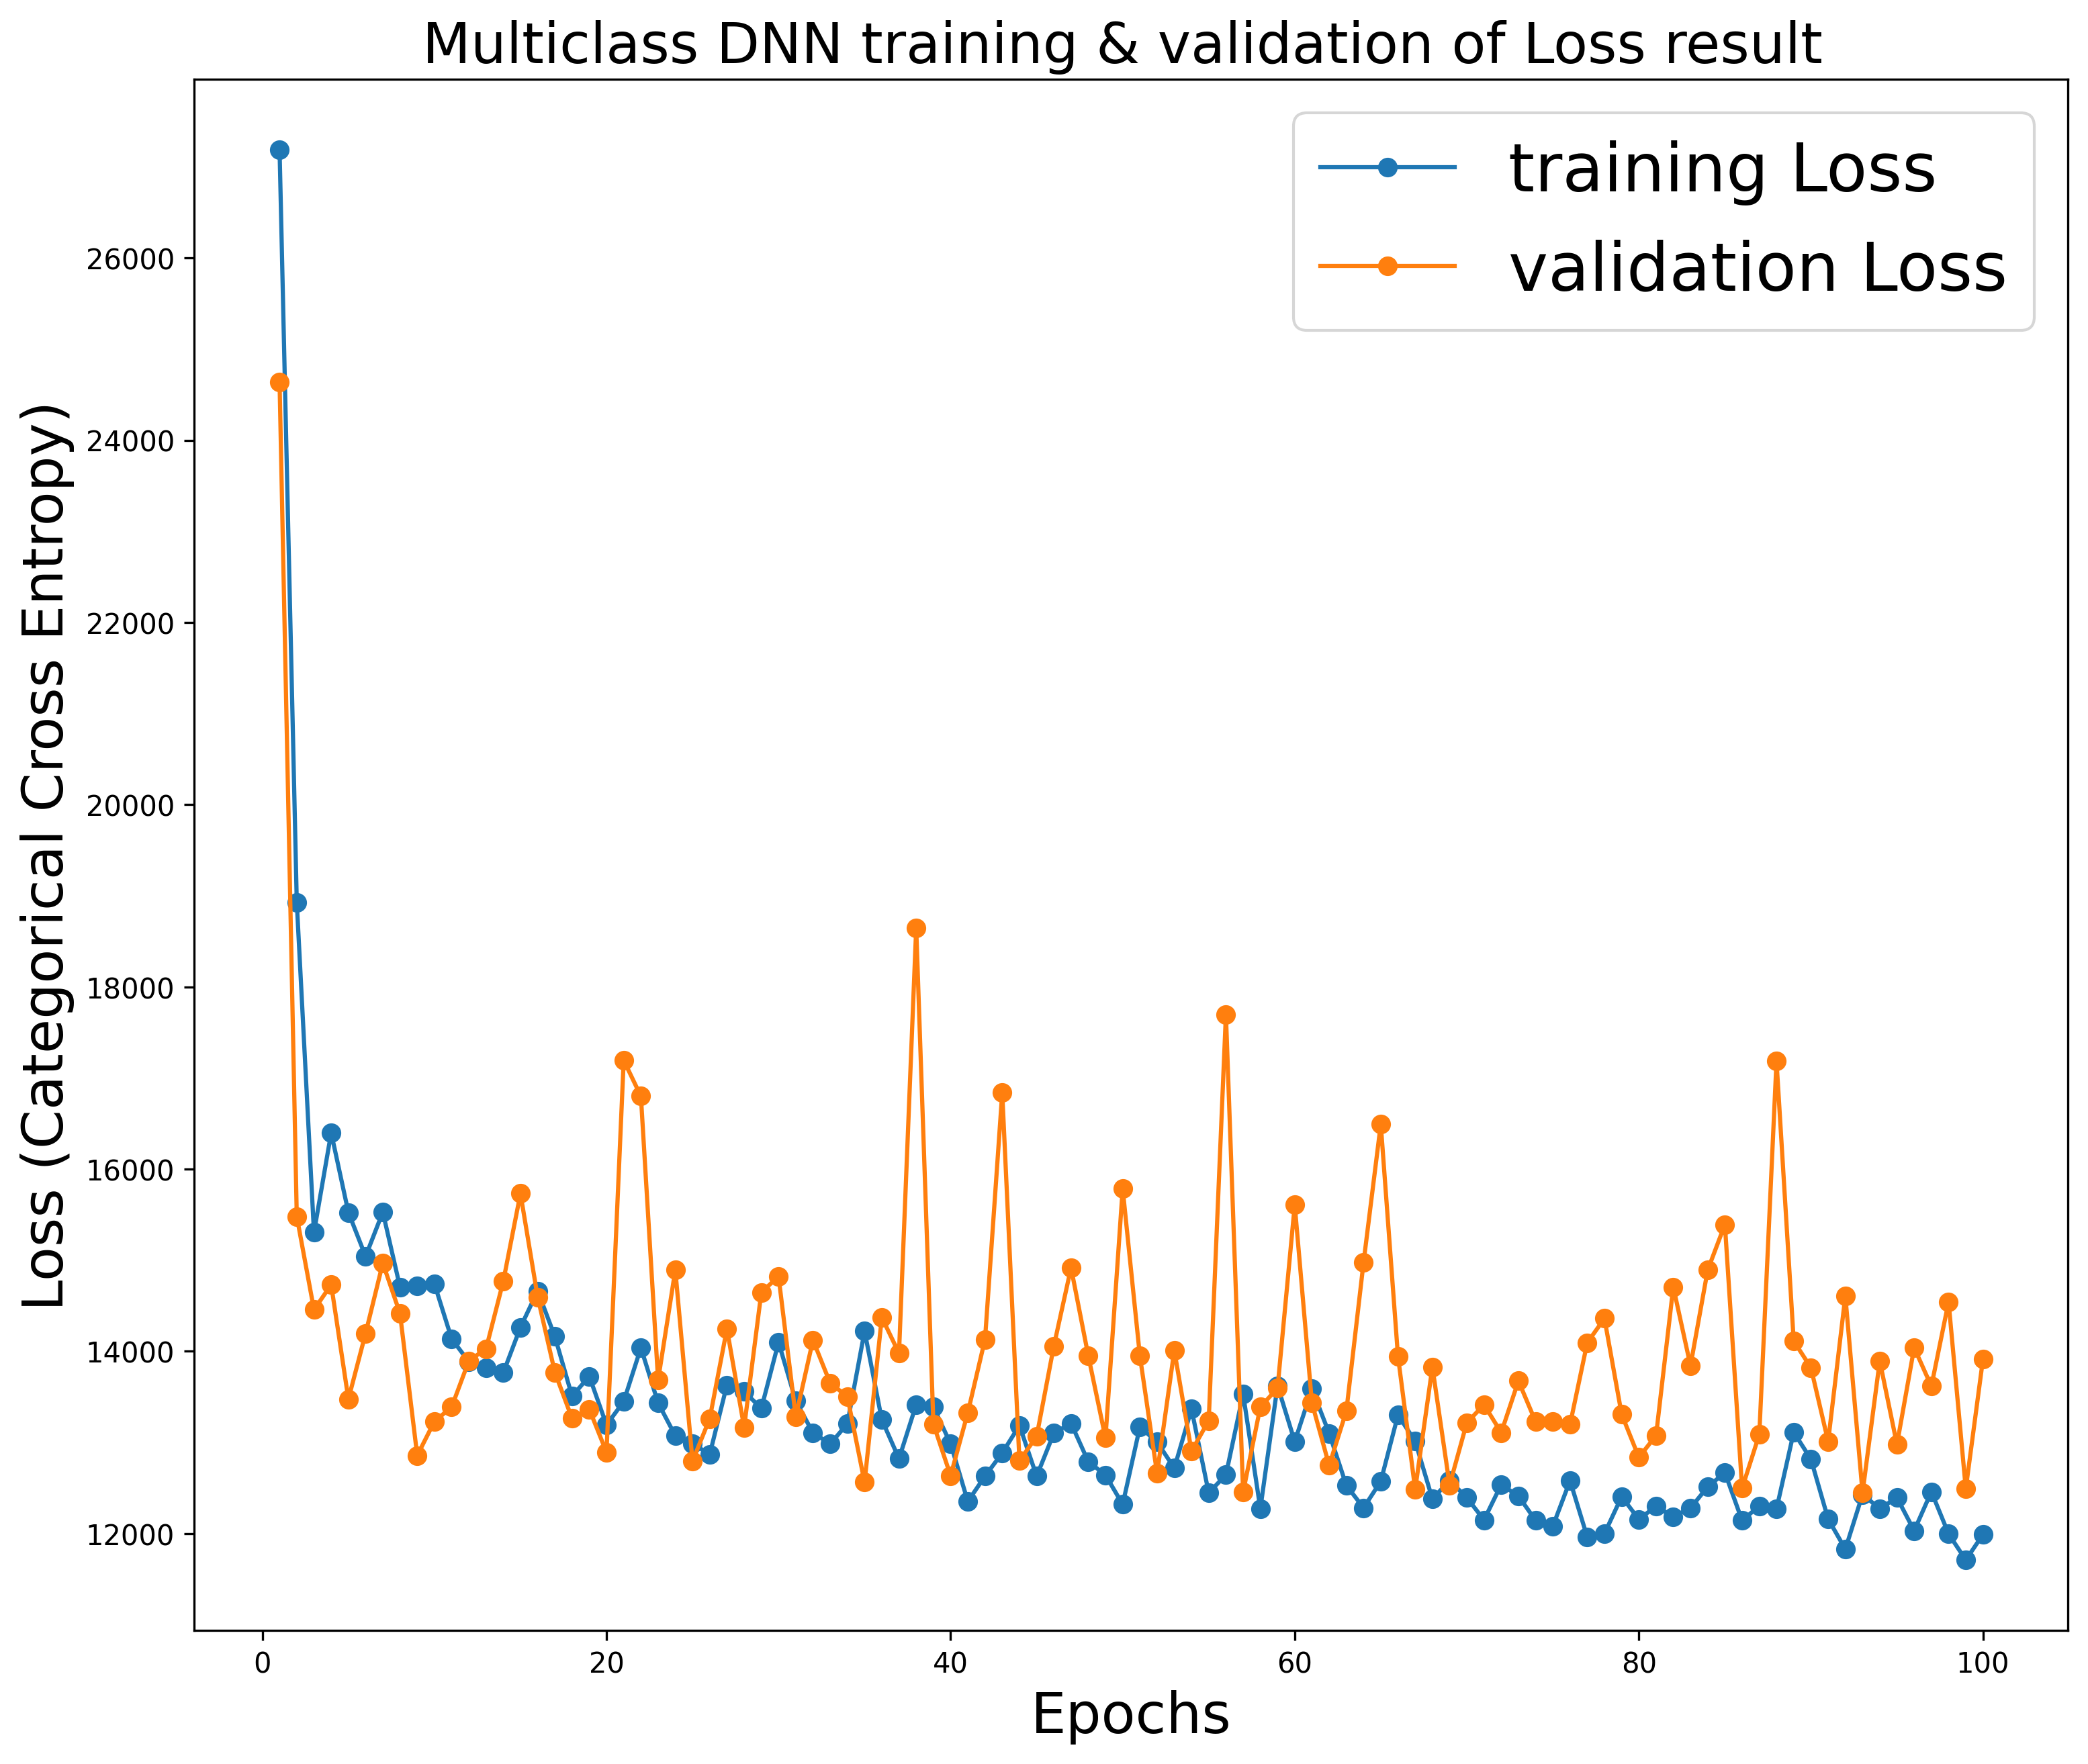

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 32ms/step - loss: 12108.5439 - MAPE: 34.3316 - val_loss: 13159.6982 - val_MAPE: 31.3547
Epoch 2/100
48/48 [==============================] - 1s 30ms/step - loss: 12559.4150 - MAPE: 34.2105 - val_loss: 14145.8721 - val_MAPE: 45.6864
Epoch 3/100
48/48 [==============================] - 1s 31ms/step - loss: 12030.8838 - MAPE: 33.8127 - val_loss: 12133.0615 - val_MAPE: 32.2268
Epoch 4/100
48/48 [==============================] - 1s 30ms/step - loss: 12412.4414 - MAPE: 34.7801 - val_loss: 12550.7324 - val_MAPE: 31.1180
Epoch 5/100
48/48 [==============================] - 1s 30ms/step - loss: 12075.7090 - MAPE: 33.4770 - val_loss: 16591.3359 - val_MAPE: 50.4669
Epoch 6/100
48/48 [==============================] - 1s 30ms/step - loss: 12211.7500 - MAPE: 34.0749 - val_loss: 19455.1113 - val_MAPE: 53.2960
Epoch 7/100
48/48 [==============================] - 2s 33ms/step - loss: 12401.6641 - MAPE: 34.0292 - val_loss: 13966.1143 - val_MAPE: 

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

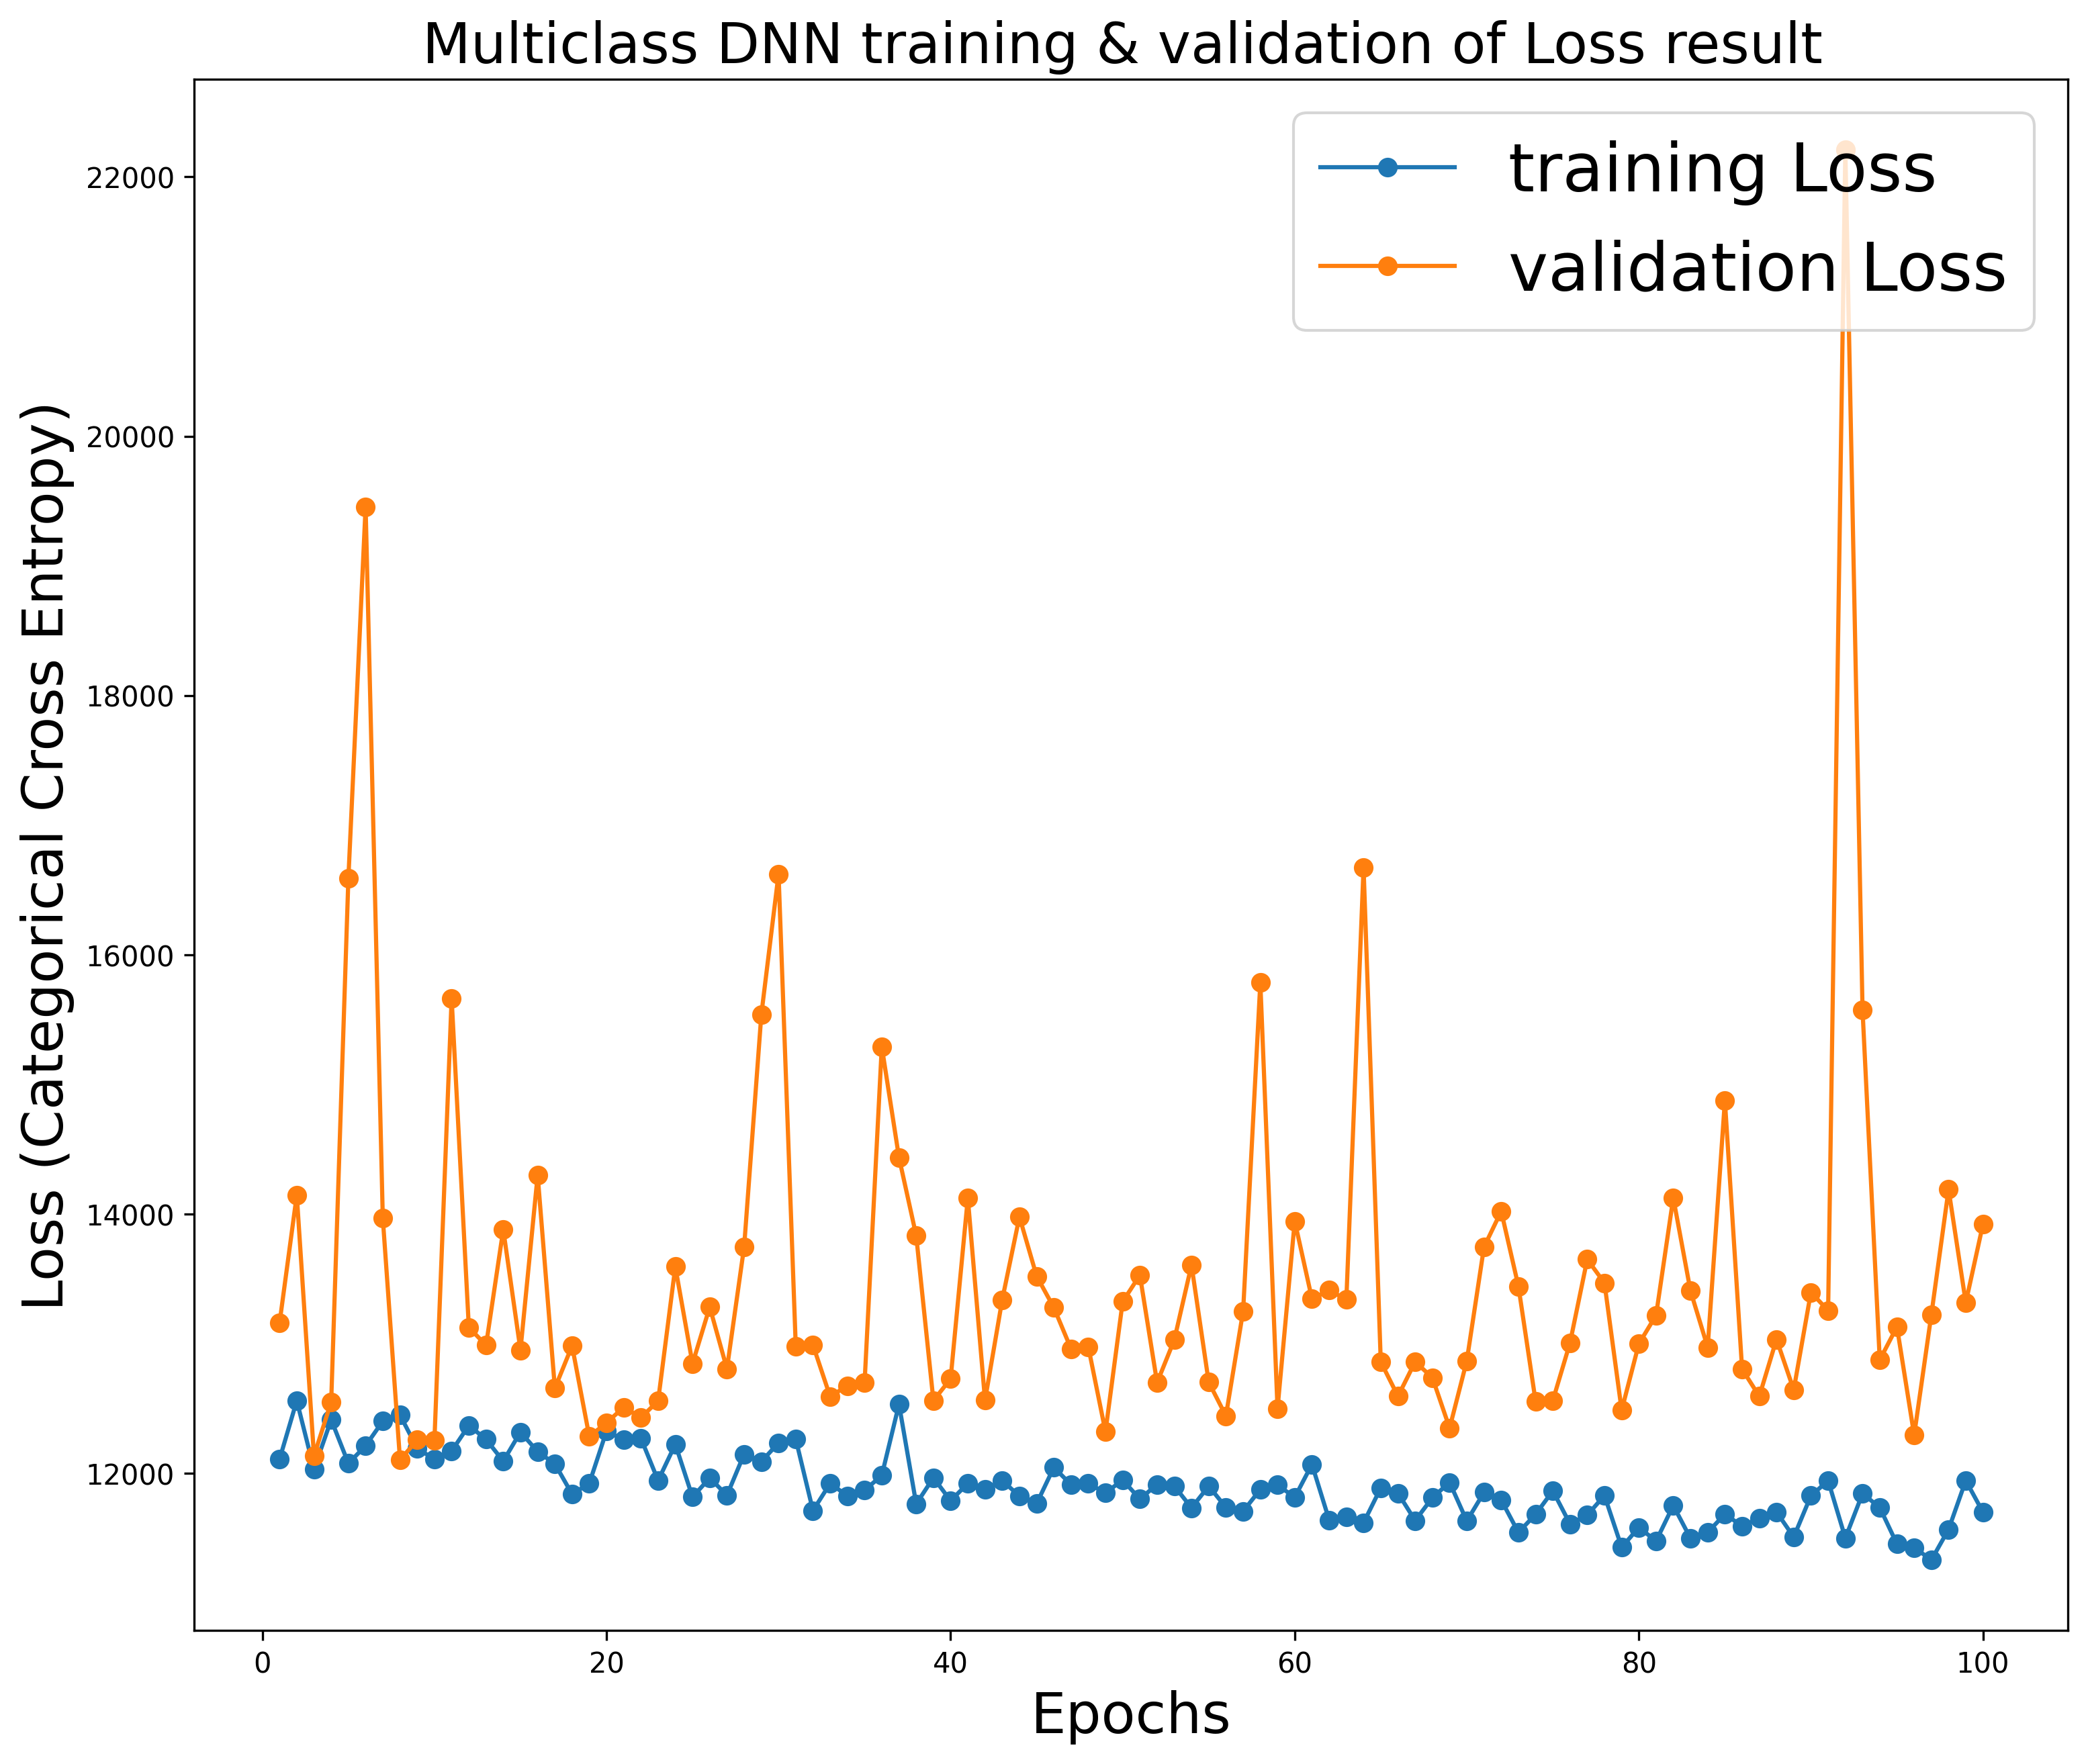

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,4,768)

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.005,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 2s 36ms/step - loss: 28251.0547 - MAPE: 90.9632 - val_loss: 34555.5352 - val_MAPE: 78.8542
Epoch 2/100
48/48 [==============================] - 2s 32ms/step - loss: 23273.0859 - MAPE: 68.5374 - val_loss: 45136.9258 - val_MAPE: 171.7321
Epoch 3/100
48/48 [==============================] - 2s 33ms/step - loss: 28998.5684 - MAPE: 90.5247 - val_loss: 16809.7168 - val_MAPE: 64.8225
Epoch 4/100
48/48 [==============================] - 2s 32ms/step - loss: 21612.7188 - MAPE: 60.8668 - val_loss: 16244.1787 - val_MAPE: 60.3076
Epoch 5/100
48/48 [==============================] - 2s 32ms/step - loss: 16899.4395 - MAPE: 49.2004 - val_loss: 20698.7383 - val_MAPE: 40.6981
Epoch 6/100
48/48 [==============================] - 2s 31ms/step - loss: 15500.1465 - MAPE: 42.1529 - val_loss: 15403.4648 - val_MAPE: 65.1876
Epoch 7/100
48/48 [==============================] - 2s 31ms/step - loss: 16068.2334 - MAPE: 44.4479 - val_loss: 14672.9854 - val_MAPE:

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'MAPE', 'val_loss', 'val_MAPE'])

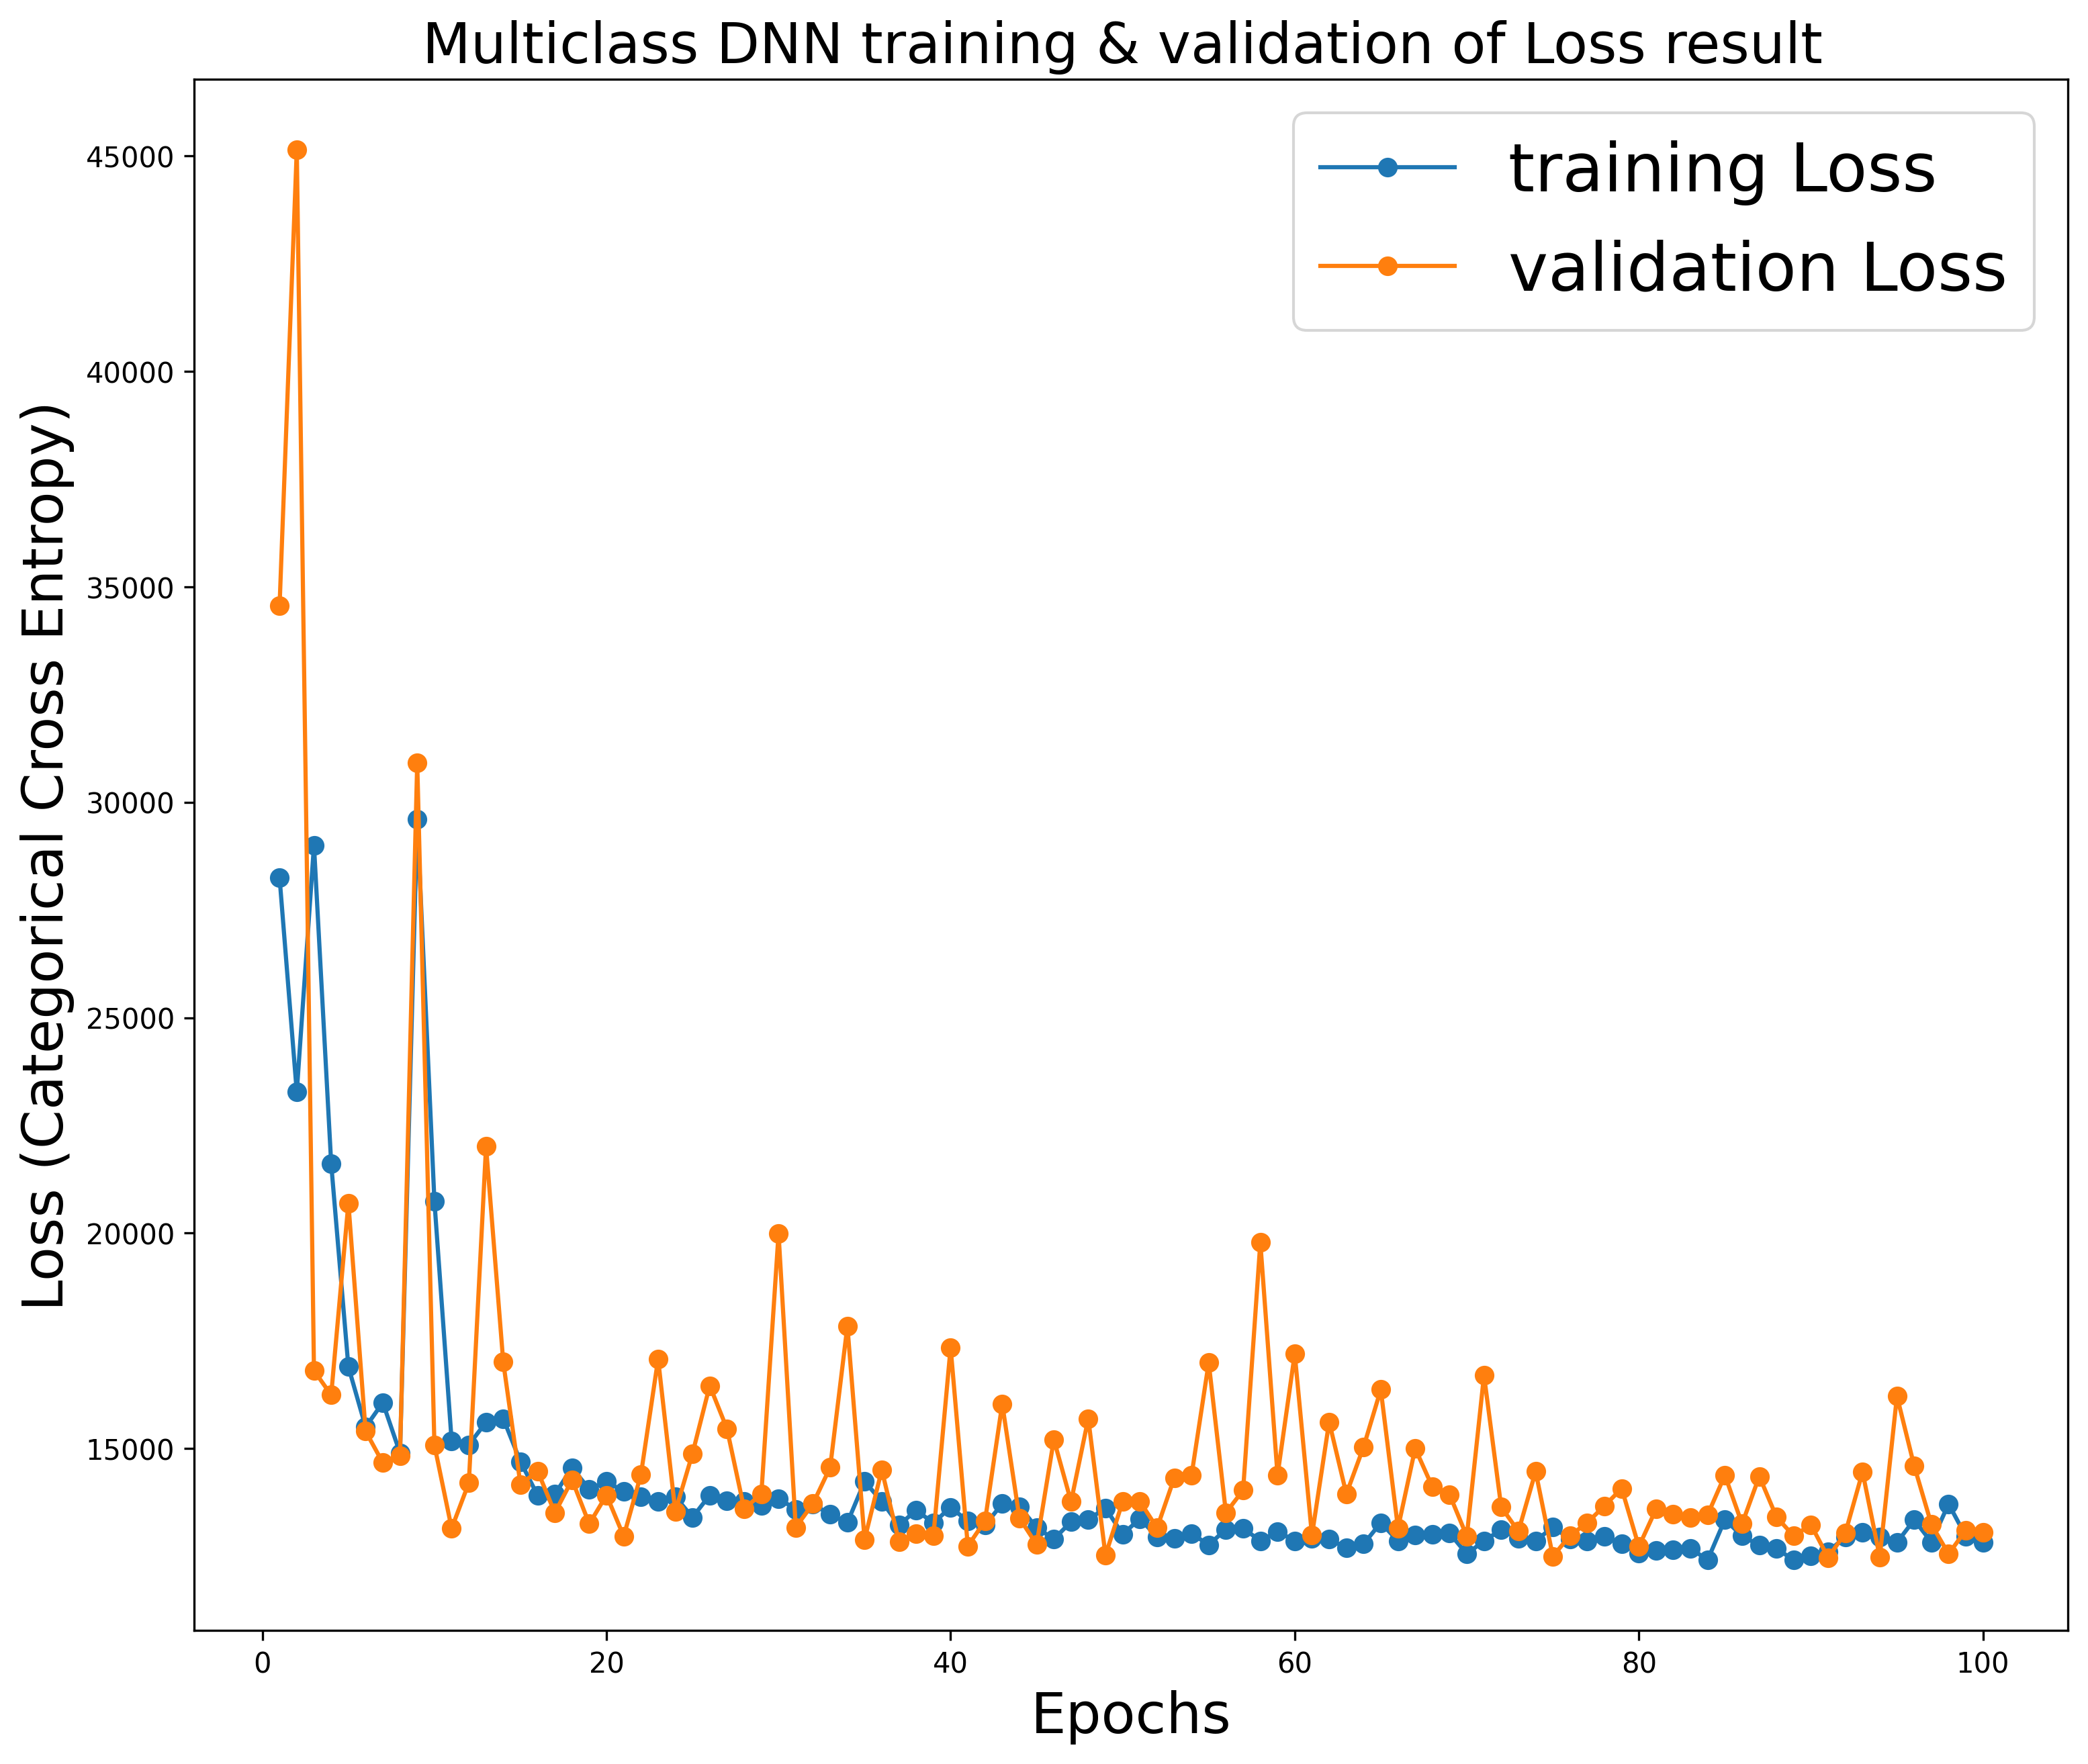

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
# with tf.device(device_name):
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add 5 dense layers
dense_generator(model,5,24)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.2)) #0.2 drop 

# 6.5 Add 5 more dense layers
dense_generator(model,5,768)


# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.7 Add output  layer
model.add(Dense(units=12, activation='linear'))

# 6.8 Compile the defined Net
opt=Adam(learning_rate=0.001,beta_1=0.5)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['MAPE']) #category loss
# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 384)               74112     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dropout (Dropout)           (None, 768)               0

In [ ]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=44)


history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 7s 129ms/step - loss: 28190.1836 - MAPE: 81.1587 - val_loss: 21594.0820 - val_MAPE: 40.1965
Epoch 2/100
48/48 [==============================] - 6s 125ms/step - loss: 24419.1309 - MAPE: 66.4943 - val_loss: 22160.6309 - val_MAPE: 98.7636
Epoch 3/100
48/48 [==============================] - 6s 124ms/step - loss: 22241.7344 - MAPE: 61.9630 - val_loss: 21649.8867 - val_MAPE: 50.7195
Epoch 4/100
48/48 [==============================] - 6s 120ms/step - loss: 22889.0098 - MAPE: 62.9277 - val_loss: 17740.8477 - val_MAPE: 36.0975
Epoch 5/100
48/48 [==============================] - 6s 118ms/step - loss: 16654.0391 - MAPE: 44.5697 - val_loss: 14357.6885 - val_MAPE: 45.4313
Epoch 6/100
48/48 [==============================] - 6s 122ms/step - loss: 16482.2031 - MAPE: 44.0918 - val_loss: 13594.1465 - val_MAPE: 33.5855
Epoch 7/100
48/48 [==============================] - 6s 118ms/step - loss: 15497.7852 - MAPE: 40.8497 - val_loss: 14508.5947 - val

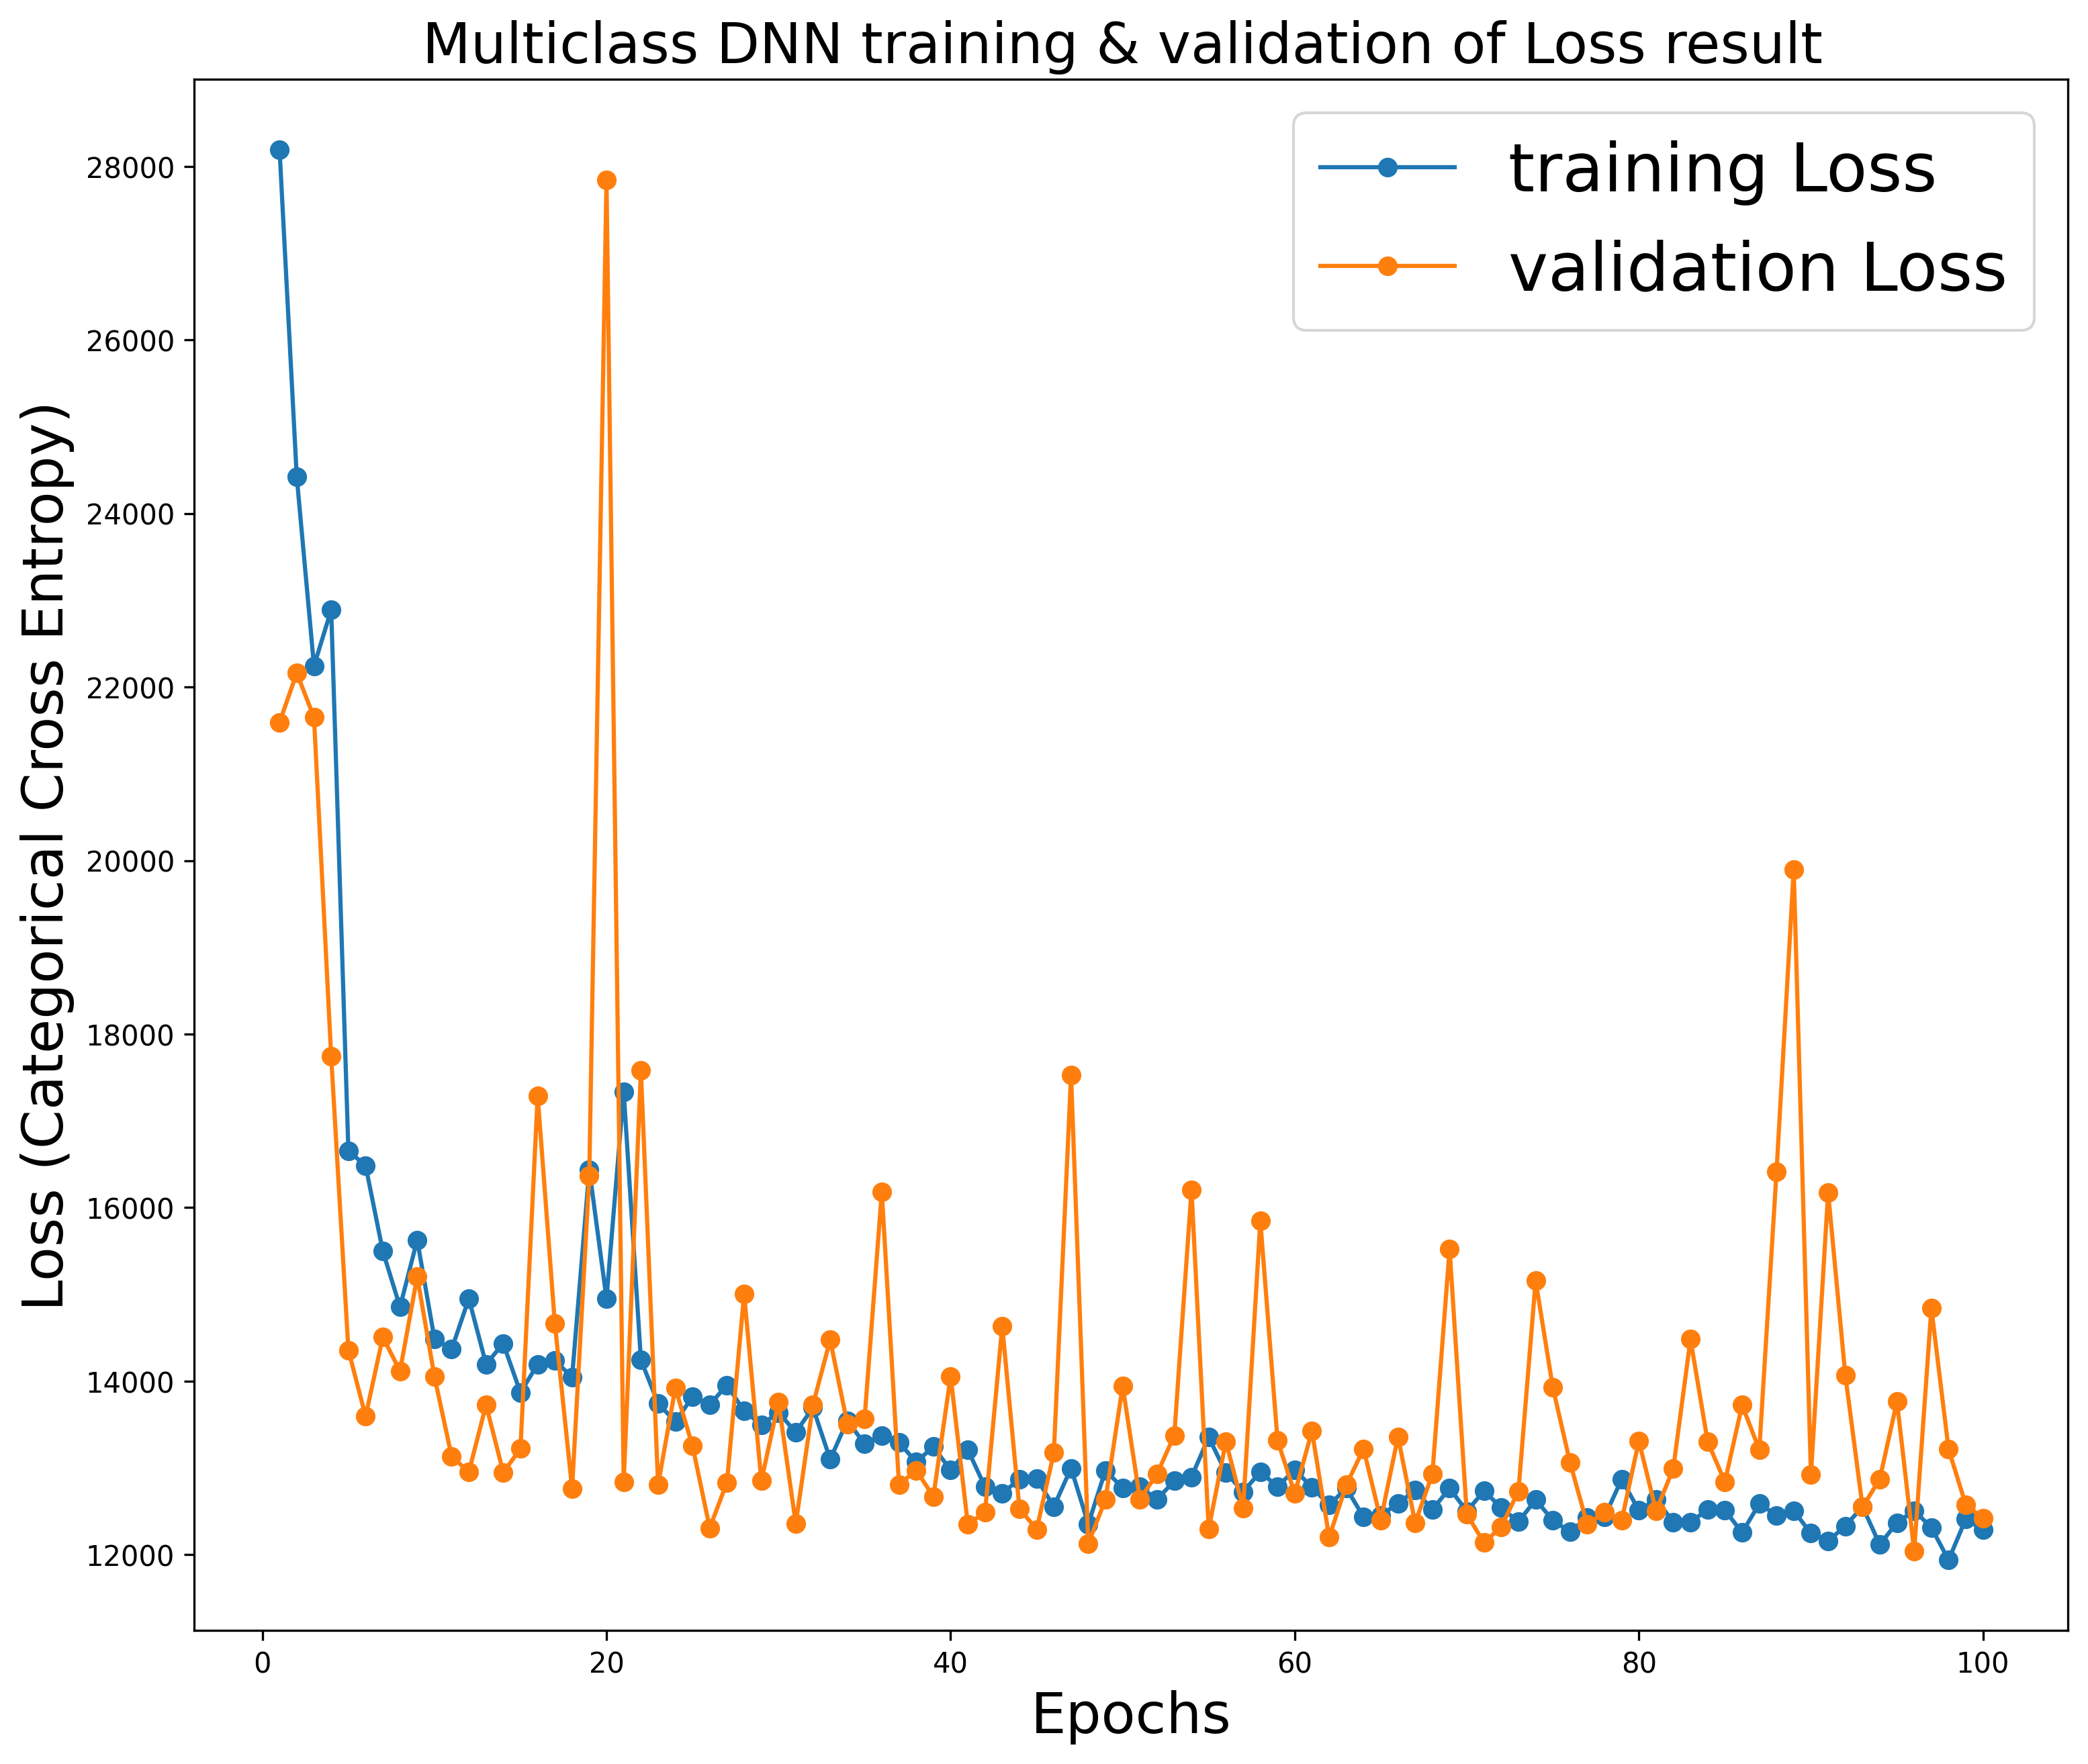

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()